In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import numpy as np

In [2]:
sys.path.append('../src/')

In [3]:
from Fast_Marching_Cython import Fast_Marching_Eikonal

In [4]:
from scipy.sparse import csr_matrix

'Quick approach for the Adj matrix Assumbling Old Scool Way'

def Adj_Unnormalized(shape):
    rows, cols = shape
    num_nodes = rows * cols
    max_neighbors = 4  # Each node can connect to at most 4 neighbors (up, down, left, right)
    
    indptr = np.zeros(num_nodes + 1, dtype=np.intc)
    indices = np.zeros(num_nodes * max_neighbors, dtype=np.intc)
    data = np.ones(num_nodes * max_neighbors, dtype=np.float64)
    
    ind = 0
    for k in range(rows):
        for l in range(cols):
            node = k * cols + l
            neighbors = []
            
            # Check right neighbor
            if l + 1 < cols:
                neighbors.append(node + 1)
            # Check left neighbor
            if l - 1 >= 0:
                neighbors.append(node - 1)
            # Check bottom neighbor
            if k + 1 < rows:
                neighbors.append(node + cols)
            # Check top neighbor
            if k - 1 >= 0:
                neighbors.append(node - cols)
            
            # Fill indices and update indptr
            indices[ind:ind + len(neighbors)] = neighbors
            ind += len(neighbors)
            indptr[node + 1] = ind
    
    # Trim unused space in indices and data arrays
    indices = indices[:ind]
    data = data[:ind]
    
    # Create the sparse matrix
    Ad = csr_matrix((data, indices, indptr), shape=(num_nodes, num_nodes))
    return Ad
            
        
    

In [6]:
' Take the middle index as sink location to start the front propagation ' 

shape = (100,100)
Ad = Adj_Unnormalized(shape)
Indices = np.array([shape[0]*shape[0]//2+shape[0]//2]).astype(np.intc) 

' Prepare grid containing arriving times set to infinity for initialization '

Test_new = np.ones(shape)*1e10
Test_new.reshape(-1)[Indices] = 0
Ind = np.zeros((Indices.shape[0],2)).astype(np.intc)
Ind[:,0] = Indices
Ind[:,1] = 1

In [12]:

from Graph_Build import adj_matrix_adaptive,adj_matrix

In [ ]:

from scipy.spatial.distance import euclidean
from scipy.sparse import csr_matrix
sys.path.append("/home/dmitrij/Documents/HDE_Code_Folder/FM_Eikonal/src/")
#from Graph_Build import adj_matrix_adaptive

def Entropy(Ad,shape):
    Ent = np.zeros(shape).reshape(-1)
    for k in range(len(Ad.indptr)-1):
        data = Ad.data[Ad.indptr[k]:Ad.indptr[k]+1]
        Ent[k] = -(data[None,:]@np.log(data)[:,None])
    return Ent.reshape(shape)

def dist(X, Y):
    """Computes the matrix out[i,j] = 0.5 * |X[i] - Y[j]|^2."""
    
# sanity checks and transformation of data:
    assert isinstance(X, np.ndarray)
    assert isinstance(Y, np.ndarray)
    assert X.ndim >= 1
    assert Y.ndim >= 1
    shape_X = X.shape
    X = X.reshape((-1,shape_X[-1]))
    shape_Y = Y.shape
    Y = Y.reshape((-1,shape_Y[-1]))

    out = - 2.0 * np.real(np.conj(X).dot(Y.T))
    out += np.sum(np.abs(X)**2, axis=1)[:,None]
    out += np.sum(np.abs(Y)**2, axis=1)[None,:]
    out = out.reshape((*shape_X[:-1],*shape_Y[:-1]))
    return 0.5*out





from scipy.ndimage.filters import gaussian_filter as gaussian 


In [17]:
from Cython_Code import* 

In [17]:
Ad2 = adj_matrix_adaptive(gaussian((Im[0:20,0:20,:]/np.max(Im[0:20,0:20,:])),sigma = 0.5),(3,3),0.005)


#Ent = Entropy(Ad,Test.shape)
#plt.imshow(np.exp(-Ent))

In [16]:
Ad.indices.m()

899

In [20]:
Ad.data.shape

(39600,)

In [19]:
Ad2.data = np.ones(Ad2.data.shape)

In [12]:
%load_ext Cython

In [13]:
%%cython -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as cnp
import cython
from cython.parallel cimport prange
from libc.stdlib cimport malloc, free
from libc.math cimport signbit,exp, pi, fmax,sqrt,abs

import time

cdef extern from "math.h"nogil:
    cdef double sqrt(double)
    cdef double pow_double "pow"(double,double)
    cdef double f_min_double "fmin"(double,double)
    cdef double f_max_double "fmax"(double,double)
    
cdef extern from "math.h":
    int pow(int,int) nogil
    int fmin(int,int) nogil

cdef extern from "pyport.h":
    double Py_HUGE_VAL

cdef double inf = Py_HUGE_VAL
    
cdef double signum(double x) nogil:
    if x > 0.0:
        return 1.0
    elif x < 0.0:
        return -1.0
    else:
        return 0.0
    
'Sort List Subroutine '
'Returns: Array Sorted Indices,Sorted Values'

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef (double*,double*) Sort(double* List,double* weights,int Length):
    
    'Help Variables'
    
    cdef int l,k,s
    cdef double S_var = 0
    cdef double W_var = 0
    
    cdef double* Sorted = <double*>malloc(Length*sizeof(double))
    cdef double* Weights_Sorted = <double*> malloc(sizeof(double)*Length)
    'Copy Array'
    
    for s in prange(Length,nogil = True):
        Sorted[s]    = List[s]
        Weights_Sorted[s] = weights[s]
        
    for k in range(Length):
        S_var = Sorted[k]
        W_var = Weights_Sorted[k]

        for l in range(k+1,Length):
            if S_var > Sorted[l]:
                S_var = Sorted[l]
                W_var = Weights_Sorted[l]
                Sorted[l] = Sorted[k]
                Weights_Sorted[l] = weights[k]
                Sorted[k] = S_var
                Weights_Sorted[k] = W_var

    return Sorted,Weights_Sorted

'Find Index Subroutine '

@cython.boundscheck(False)
@cython.wraparound(False)

cdef Find_Index(int* Array, int Val,Length):
    
    'Auxiliary Variables'
    
    cdef int Index, k
    
    for k in range(Length):
        if Array[k] ==  Val:
            Index = k
            break
        else:
            continue
    return Index

' Check if Index in Array '

@cython.boundscheck(False)
@cython.wraparound(False)

cdef void Check_Index(int [:] Array, int Index,int* response) nogil:
    
    'Auxiliary Variables'
    
    cdef int Length = Array.shape[0]
    cdef int k
    
    for k in range(Length):
          
        if Array[k] == Index:
            
            response[0] = 1
            
            break
            

            
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(False)

cdef void Check_Index_pt(bint* Narr_Band_ind,int Index, int* response) nogil:
    
    'Auxiliary Variables'

          
    if Narr_Band_ind[Index] == True:
            
        response[0] = 1
            

' Append Index to last position in an array Array '

@cython.boundscheck(False)
@cython.wraparound(False)

cdef Append_Ind(cnp.ndarray[int,ndim = 1] Array, int Index):
    Array = np.append(Array,Index).astype(np.int32)
    return Array
    
    

' Delete Index on first position in an array Array '

@cython.boundscheck(False)
@cython.wraparound(False)

cdef Delete_Ind(cnp.ndarray[int,ndim = 1] Array, int Index):
    
    Array = np.delete(Array,Index).astype(np.int32)
    return Array

' Append Value to last position in an Value Array '

@cython.boundscheck(False)
@cython.wraparound(False)

cdef Append_Val(cnp.ndarray[double,ndim = 1] Array_Val, double Val):
    cdef cnp.ndarray[double,ndim  = 1] Up_Array = np.append(Array_Val,Val)
    return Up_Array
       
                
                 
' Bubble Sort Subroutine for value of one vertex while other are fixed '
' Returns:   Updated Value of vertex with minimal arrival time within the Narrowband '

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef double Local_Solution(double* a_i,double Vel,double p,double* w_i,int vertex, int End_Point):
    
    ' Compute the gradient on the grid (Characterization of P(x,y)) '
    
    ' a_i __ Values within the Narrow_Band cut Neighbouhood '
    
    # Allocate Array for gradient values 
    
    cdef int k
    
    cdef double Grad_min = Vel 
    cdef double* a_i_sorted
    cdef double* w_i_sorted
    cdef double Local_Solution = 1e10 # Set large to go to the loop
    cdef int l,s,j,index,Iter_Patsch,Length_NPatch,h,y,f,w
    cdef int m = 0

    a_i_sorted,w_i_sorted = Sort(a_i,w_i,End_Point)
    for k in range(End_Point):
        print("Sorted",a_i_sorted[k])
    
    if p == 1.0:
        while Local_Solution >= a_i_sorted[m+1] and m <= End_Point-1:
            Local_Solution = Solve_Subproblem(a_i_sorted,w_i_sorted,Grad_min,p,vertex,m+1)  
            print("Local_Solution",Local_Solution)
            m += 1
    
    elif p == 2.0:
        while Local_Solution >=a_i_sorted[m+1] and m <= End_Point-1:
            Local_Solution = Solve_Subproblem(a_i_sorted,w_i_sorted,Grad_min,p,vertex,m+1)
            m += 1
    elif p == 3.0:# infinity
        Local_Solution = a_i_sorted[0]+w_i_sorted[0]
            #print("Local_Solution",Local_Solution)
    
    #Local_Solution = f_min_double(Local_Solution,a_i[0])
    free(a_i_sorted)
    free(w_i_sorted) 
    
    return Local_Solution

' Subroutine for minimal time arrival value '

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef double Solve_Subproblem(double* a_i,double* w_i_sorted,double Norm,double p,int local_vertex, int End_Point):
    
    cdef double Sol = 0
    cdef double Term = 0
    cdef double Value_Inner_Loop 
    cdef double h_i_normalized = 0
    cdef int l,s,i,j,index,k,Iter_Patsch,Length_NPatch,h,y,f,w
        
    if p == 1.0:
        for l in range(End_Point):    
            Sol += a_i[l]*sqrt(w_i_sorted[l])
            h_i_normalized += sqrt(w_i_sorted[l])
        Sol += Norm
                
    elif p == 2.0:
        for i in range(End_Point):
            Value_Inner_Loop = 0

            for j in range(i+1,End_Point):
                Value_Inner_Loop += pow_double((a_i[i]-a_i[j]),2.0)*w_i_sorted[i]*w_i_sorted[j]

            Term += pow_double(Norm,2.0)*w_i_sorted[i]-Value_Inner_Loop

            Sol += a_i[i]*w_i_sorted[i]
        Sol += sqrt(Term)
        for s in range(End_Point):
            h_i_normalized += w_i_sorted[s]
            
    return Sol/h_i_normalized 


' Subroutine for updating Narrow_Band '

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef inline (int*,double*) Update_Narrow_Band( int* indptr, int* indices, \
                    double* Narrow_Band_Val, int* Narrow_Band,int* Indices,\
                    double* Image_Data_Graph, double* h_i,int Length_In,int* Length_Narrow,\
                    int Min_Index, int* levels,int* count,bint* Indices_Far_Away_bool,\
                    bint* Indices_Narrow_bool,double* Vel,double p):
    
    'Create Variables auscilary Variables'
    
    cdef int j,i,k,l
    cdef int del_index = 0
    cdef double Help   = 0
    cdef int* Narrow_Band_Up 
    cdef double* Narrow_Band_Val_Up
    ' New Index, Value List within the Narrow Band '
        
    cdef int Stop = 0
    cdef int Response, Response_1
    cdef int number = Length_Narrow[0]
    cdef double Neigh_value
    cdef int count_pt  = count[0]
    cdef int levels_pt = levels[0]
    cdef int Length_neigh_j
    cdef int* Narrow_Band_pt = &Narrow_Band[0]
    cdef double* Narrow_Band_Val_pt = &Narrow_Band_Val[0]
    cdef int del_index_1 = 0
    cdef int index_up 
    cdef double* Image_Data_Graph_pt
    cdef double* h_i_pt
    
    for j in range(Length_In):
        Length_neigh_j = indptr[indices[indptr[Min_Index]+j]+1]-indptr[indices[indptr[Min_Index]+j]]
        Image_Data_Graph_pt = <double*> malloc(sizeof(double)*Length_neigh_j)
        h_i_pt = <double*> malloc(sizeof(double)*Length_neigh_j)
        Response    = 0
        Response_1  = 0
        del_index   = 0
        del_index_1 = 0
        
        
        ' Check if the index is in Narrow_Band then update solution '

        Check_Index_pt(Indices_Narrow_bool,Indices[j],&Response)
        Check_Index_pt(Indices_Far_Away_bool,Indices[j],&Response_1)
            
        for k in range(Length_neigh_j):
            Image_Data_Graph_pt[k] = Image_Data_Graph[indices[indptr[indices[indptr[Min_Index]+j]]+k]]
            h_i_pt[k] = h_i[indptr[indices[indptr[Min_Index]+j]]+k]

        Help = Local_Solution(&Image_Data_Graph_pt[0],Vel[indices[indptr[Min_Index]+j]],p,h_i_pt, j,Length_neigh_j)
        #print("Help",Help)
        
        if Help < Image_Data_Graph[indices[indptr[Min_Index]+j]]:
            Image_Data_Graph[indices[indptr[Min_Index]+j]] = Help
            if Response_1 == 1:
                print("Response_1")
                'Set Index in Far_Away to -1 to ignore it '
                
                Indices_Far_Away_bool[Indices[j]] = False

                ' Find Index in Far_Away with value Indices[j] '
                    
                Neigh_value  = Image_Data_Graph[indices[indptr[Min_Index]+j]]

                ' If indices positions exceed add new level '

                if count_pt+1 > number-pow(2,levels_pt-1):

                    ' Update Narrowband size '
                    
                    number += pow(2,levels_pt)

                    ' Add Level to Binary Heap '

                    Narrow_Band_Val_Up,Narrow_Band_Up = add_level(Narrow_Band_pt, Narrow_Band_Val_pt,Length_Narrow,\
                                                                &levels_pt,add = 1)
                    

                    print("levels_pt_before",levels_pt)
                    print("count_pt_before",count_pt)
                    levels_pt += 1
                    Min_Heap_Insert(Narrow_Band_Up, Narrow_Band_Val_Up, indices[indptr[Min_Index]+j],Neigh_value,\
                                                                                                        count_pt)
                    count_pt += 1 
                    print("levels_pt_after",levels_pt)
                    print("count_pt_after",count_pt)
                    print("Number",number)
                    Narrow_Band_pt = &Narrow_Band_Up[0]
                    Narrow_Band_Val_pt = &Narrow_Band_Val_Up[0]
                else: 
                    print("Second_Else")
                    Narrow_Band_Val_Up = Narrow_Band_Val_pt
                    Narrow_Band_Up     = Narrow_Band_pt
                    print("count_pt_before",count_pt)
                    Min_Heap_Insert(Narrow_Band_Up, Narrow_Band_Val_Up, indices[indptr[Min_Index]+j],Neigh_value, count_pt)
                    count_pt += 1
                    print("count_pt_after",count_pt)
                    print("Number",number)
                    Narrow_Band_pt = &Narrow_Band_Up[0]
                    Narrow_Band_Val_pt = &Narrow_Band_Val_Up[0]
            elif Response == 1:
                print("Response")
                print("Number",number)
                Narrow_Band_Val_Up = Narrow_Band_Val_pt
                Narrow_Band_Up     = Narrow_Band_pt
                Min_Heap_Update_Node_Pos(Narrow_Band_Up, Narrow_Band_Val_Up,indices[indptr[Min_Index]+j],\
                       Neigh_value,count_pt,number)
                Narrow_Band_pt = &Narrow_Band_Up[0]
                Narrow_Band_Val_pt = &Narrow_Band_Val_Up[0]
                print("Number",number)

            
          
        free(Image_Data_Graph_pt)
        free(h_i_pt)
        
    count[0]  = count_pt
    levels[0] = levels_pt
    Length_Narrow[0] = number
    
    return Narrow_Band_pt,Narrow_Band_Val_pt

""""

Returns indices_1\indices indices_1 of type arange(Length_graph)

"""

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(False)

cdef void set_diff_cython(int [:] indices,bint* Far_Away_pt,int Length_Indices):

    cdef int k
    
    for k in range(Length_Indices):
        
        Far_Away_pt[indices[k]] = False
        
' If index is in Far_Away return the position of the index within the Far_Away array ' 

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef void Min_Heap_Update_Node_Pos(int* narr_band_ref, double* narr_band_val,int index,double Value,\
                                   int count,int Heap_Size):
    cdef int Index_node = -1
    cdef int parent,left,right
    cdef bint Min_Heap = False
    cdef double Aux_val
    cdef int m = 0
    cdef int Aux_ind
    for k in range(count):
        if narr_band_ref[k] == index:
            narr_band_val[k] = Value
            Index_node = k
            break
    if Index_node == -1:
        Min_Heap = True
        print("Not in Narrow Band Something wrong")

    ' Update Min Heap '
    #print("CheckMin_Heap_Update_")
    while Min_Heap == False and m < Heap_Size:
        parent = int((Index_node -1)/2)
        left  = Index_node*2+1
        right = Index_node*2+2
        if narr_band_val[parent] > narr_band_val[Index_node]:
            #print("EnterFirst")
            ' Move Up '
            Aux_ind = narr_band_ref[parent]
            Aux_val = narr_band_val[parent]
            narr_band_val[parent] = narr_band_val[Index_node]  
            narr_band_ref[parent] = narr_band_ref[Index_node]
            narr_band_val[Index_node] = Aux_val
            narr_band_ref[Index_node] = Aux_ind
            Index_node = parent
        elif (left < Heap_Size and right < Heap_Size ):
            #print("Index_Node",narr_band_val[Index_node])
            #print("Right",narr_band_val[right])
            #print("Left",narr_band_val[left])
            #print("EnterSecond")
            ' Move Up '
            if narr_band_val[Index_node] > narr_band_val[left] or narr_band_val[Index_node] > narr_band_val[right]:
                ' Determine which child to be moved to the top '
                parent = Index_node
                if narr_band_val[parent] > narr_band_val[left]:
                    parent = left
                if narr_band_val[parent] > narr_band_val[right]:
                    parent = right
                ' Swap with smallest child '
                Aux_ind = narr_band_ref[Index_node]
                Aux_val = narr_band_val[Index_node]
                narr_band_val[Index_node] = narr_band_val[parent]  
                narr_band_ref[Index_node] = narr_band_ref[parent]
                narr_band_val[parent] = Aux_val
                narr_band_ref[parent] = Aux_ind
                Index_node = parent
            else:
                Min_Heap = True
        else:
            Min_Heap = True
        m += 1
                
        
    
    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(False)

cdef void Intersect_Cython(bint* Far_Away_ind,int Check_index,int* Response)nogil:
        
    if Far_Away_ind[Check_index] == True:
            
        Response[0] = 1


' Function to remove index from the binary Min-Heap '

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef inline (int*,double*) Rem_Min_Index_Binary_Heap(int* narr_band_ref, double* narr_band_val,int* levels,\
                                                     int* count,int* size_narrow):
            
    cdef int End_Ind = count[0] - 1
    cdef double Aux_val
    cdef int Aux_ind
    cdef int left,right,parent,parent_aux
    cdef int i
        
    ' Define Pointer to allocated arrays '
        
    cdef int* narr_band_ref_pt    
    cdef double* narr_band_val_pt
    cdef int levels_pt 
        
    ' Swap Min-Node and Last node of the Binary Heap '
    
    narr_band_val[0] =  narr_band_val[End_Ind] 
    narr_band_ref[0] = narr_band_ref[End_Ind] 
    narr_band_val[End_Ind] = 1e10
    narr_band_ref[End_Ind] = -1
            
    ' Set index to the last element '
        
    count[0] -= 1
    parent = 0
    parent_aux = parent
    left = parent*2+1
    right =  parent*2+2
    #print("CheckRem_Min_Index_")
    while  narr_band_val[parent] > narr_band_val[left] or narr_band_val[parent] > narr_band_val[right]:
        if narr_band_val[parent_aux] > narr_band_val[left]:
            parent_aux = left
        if narr_band_val[parent_aux] > narr_band_val[right]:
            parent_aux = right
        if parent_aux != parent:
            Aux_ind = narr_band_ref[parent]
            Aux_val = narr_band_val[parent]
            narr_band_val[parent] = narr_band_val[parent_aux]  
            narr_band_ref[parent] = narr_band_ref[parent_aux]
            narr_band_val[parent_aux] = Aux_val
            narr_band_ref[parent_aux] = Aux_ind
            parent = parent_aux
            left = parent*2+1
            right =  parent*2+2
        if left > size_narrow[0] or right > size_narrow[0]:
            break 
    
    ' If empty Level remove level from Min-Heap '
    print("size_narrow_before_if",size_narrow[0])
    print("Levels_Add_Func",levels[0])
    if  (count[0] < size_narrow[0]-pow(2,levels[0]-1)):
        narr_band_ref_pt = &narr_band_ref[0]             
        narr_band_val_pt = &narr_band_val[0]
        levels_pt = levels[0]
        print("size_narrow_before",size_narrow[0])
        narr_band_val_pt,narr_band_ref_pt = add_level(narr_band_ref_pt, narr_band_val_pt,size_narrow, &levels_pt,add = -1) 
        levels[0] = levels[0] - 1
        print("size_narrow_after",size_narrow[0])
    else:        
        levels_pt        = levels[0]
        narr_band_ref_pt = &narr_band_ref[0]             
        narr_band_val_pt = &narr_band_val[0]

         
    
    return narr_band_ref_pt, narr_band_val_pt

' Function to extract the minimal value and index from the binary tree '

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef inline (double,int*,double*) Get_Index_Narrow_Cython(int* levels, double* current_values,\
                    int* current_reference,int* popped_ref,int* count,int* size_narrow):
    
    
    cdef double value
    cdef int* current_reference_pt
    cdef double* current_values_pt
        
    ' Pick the index with the lowest value located at the top of the binary heap'
    #print("current_values[i]")
    #print(current_values[0])
    
                                                
    ' Return current reference index and value '  
    value = current_values[0]
    popped_ref[0] = current_reference[0]
    #print("current_reference[local_index]")
    #print(current_reference[0])
    #print("Min Values:__")
    #print(value)
    
    
    ' Remove index '
        
    current_reference_pt = &current_reference[0]   
    current_values_pt    = &current_values[0]
    cdef int count_pt 
    count_pt = count[0]
    cdef int levels_pt      = levels[0]
    cdef int size_narrow_pt = size_narrow[0]
    current_reference_pt,current_values_pt = Rem_Min_Index_Binary_Heap(current_reference_pt,current_values_pt\
                                                        ,&levels_pt,&count_pt,&size_narrow_pt)
    
    count[0]       = count_pt
    levels[0]      = levels_pt
    size_narrow[0] = size_narrow_pt
    
    return value,current_reference_pt,current_values_pt            


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef void Min_Heap_Insert(int* array_indices,double* array_values,int index,double value,int Ind_Heap):
    
    cdef int i = Ind_Heap
    cdef double Aux_val
    cdef int Aux_ind
    cdef int parent_ind
    'Insert at the end '
    array_values[Ind_Heap] = value
    array_indices[Ind_Heap] = index
    
    'Order the Min-Heap'
    if Ind_Heap == 0:
        array_indices[Ind_Heap] = index
        array_values[Ind_Heap] = value
    else:
        parent_ind = int((Ind_Heap-1)/2)
        #print("parent_ind",parent_ind)
        #print(array_values[parent_ind])
        #print(array_values[i])

        while array_values[parent_ind] > array_values[i]:
            Aux_val = array_values[parent_ind]
            Aux_ind = array_indices[parent_ind]
            array_values[parent_ind] = array_values[i]
            array_indices[parent_ind] = array_indices[i]
            array_values[i] = Aux_val
            array_indices[i] = Aux_ind
            i = parent_ind
            parent_ind = int((i-1)/2)
            #print("parent_ind_while",parent_ind)


        
    
    
"""
Comment: Dmitrij Sitenko
Function to add or to remove one level of Binary Min Heap:

Input: 1) Number of new Levels
       2) reference, values arrays to be modified
       3) Number of old Levels
       4) new empty reference and values arrays initialized before function call    
"""

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef (double*,int*) add_level(int* old_reference, double* old_values,int* number_nodes, int* old_levels,int add):
     
    ' Initialization '
        
    cdef int i,k, level_start_old, level_start_new , n
    cdef int number_nodes_new = number_nodes[0]
    
    if add == 1:      
        number_nodes_new += pow(2,old_levels[0])
        #print("Number_nodes_new",number_nodes_new)
    elif add == -1:
        number_nodes_new -= pow(2,old_levels[0]-1)
    
    Narrow_Band_Val_Up    = <double*>malloc(number_nodes_new*sizeof(double))
    Narrow_Band_Up        = <int*>malloc(number_nodes_new*sizeof(int))
    
    ' Assign elements to infinity '
    
    for i in prange(number_nodes_new,nogil = True): 
        Narrow_Band_Val_Up[i] = 1e10
    
    for i in prange(number_nodes_new,nogil = True):
        Narrow_Band_Up[i] = -1
    
    ' Write old ref and vals from last old level to last new level '
    
    n = fmin(number_nodes_new, number_nodes[0])
    
    for i in prange(n,nogil = True):
        Narrow_Band_Val_Up[i] = old_values[i]
        Narrow_Band_Up[i] = old_reference[i]
    
    free(old_values)
    free(old_reference)
    
    ' Update the binary tree from bottom to top level ' 
    
    number_nodes[0] = number_nodes_new
    
    return &Narrow_Band_Val_Up[0],&Narrow_Band_Up[0]
            

' Variables Settings '

' Image             ______  Input Image 2D 3D reshape to 1D array' 
' Ad                ______  Graph as 1D array in a matrix sparse format containing data driven weights ' 
' Seeds_indices     ______  Start for Tracking Points setted to zero  '
' Distance          ______  Time Distance Output as 1 D array (Trace back via Ad Matrix to 2D,3D data)'
' Active List       ______  Optimal values of time '
' Narrow_Band       ______  Points on Active List complnement such that there exists one Neighbour within Active_List'
' Narrow_Band_Val   ______  1D array for keeping the current values for indices'
' Far_Away          ______  Ramaining Grid-Points'
' Image_Data_Graph  ______  Adopted weights values of the input image to the grid (a_i input) '


' Termination Criterium :      Empty Narrow_band '

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cpdef Eikonal_Eq_Solve_Cython(double [:] Image,double[:] Velocity,double [:] data,int [:] indices,int [:] indptr,int[:,:] Seeds_indices, int [:] shape_ad,double p):
    
    assert len(data.shape) == len(indices.shape), ' data and indices not of equal shape '
    
    cdef int Length_Graph = Image.shape[0]
    cdef int k,l,i
    
    cdef double [:] Image_Data_Graph = Image.copy() # Array of reshaped arrival times set to zero at seeds indices 
    #print("Seeds_indices.shape[0]",Seeds_indices.shape[0])
    for k in range(Seeds_indices.shape[0]):
        Image_Data_Graph[Seeds_indices[k,0]] = 0
    
    
    ' Initialization '
    
    cdef cnp.ndarray[ndim = 1, dtype = int,negative_indices = False] Active_List         = np.zeros(\
                                                                 Length_Graph,dtype = np.int32)
    cdef cnp.ndarray[ndim = 1, dtype = double,negative_indices = False] Active_List_Val  = np.zeros(\
                                                                             Length_Graph,)
    
    
    ' Create List for Intersect Indices '
    
    cdef bint* Indices_Narrow_bool = <bint*>malloc(sizeof(bint)*Length_Graph)
    cdef bint* Indices_Far_Away_bool = <bint*>malloc(sizeof(bint)*Length_Graph)
    
    for k in prange(Length_Graph,nogil = True):
        Indices_Narrow_bool[k] = False 
        Indices_Far_Away_bool[k] = True
    
    for k in range(Seeds_indices.shape[0]):
        Active_List[k]          = Seeds_indices[k,0]
        Active_List_Val[k]      = Image_Data_Graph[Seeds_indices[k,0]] 
        Indices_Far_Away_bool[Seeds_indices[k,0]] = False #Remove Index from boolean Far_Away array
        
    cdef int* Response
    cdef int allocate_count = 0
    
    #########################################
    #########################################
    ########## ' Initilize Far_Away ' #######
    #########################################
    #########################################
    
    ' Compute setdifference '
    
    set_diff_cython(Active_List,&Indices_Far_Away_bool[0],Seeds_indices.shape[0])
    
    ############################################################################
    
    ' Initilize empty Narrow_Band through a Min-Heap-Structure with initial capacity 256 '
    
    cdef int initial_capacity = 0
    cdef int levels = 0
    cdef int nodes_number = 0
    while initial_capacity < Seeds_indices.shape[0]:
        initial_capacity += pow(2,levels)
        levels += 1
    print("Levels",levels)
    print("Initial_Capacity",initial_capacity)
    
    ' Number of Stored Values '
    
    cdef int count = 0
    
    ' Initialize Number Of Levels '
    cdef int lev = 0
    while nodes_number <= initial_capacity:
        nodes_number += pow(2,lev)
        lev += 1
    levels = lev
    print("Nodes_Number",nodes_number)

    ' Allocate memory for two arrays for binary min heap ' 
        
    cdef double* nodes_values = <double*> malloc(nodes_number*sizeof(double)) # Current Values of min time arrivels
    cdef int* references_array = <int*>malloc(nodes_number*sizeof(int))       # Corresponding Indices on Image grid 
    
    for k in range(nodes_number):  
        nodes_values[k] = 1e10
        references_array[k] = -1
    
    cdef double* nodes_values_pt
    cdef int* references_array_pt
    
    ' Create Narrow Band '
   
    cdef int Neigh_ind
    cdef double Neigh_value
    cdef int Check_Index 
    cdef double* new_values
    cdef double* new_values_pt
    cdef int* new_reference
    cdef int* new_reference_pt
    cdef int index_up
    cdef int Int_index = 0
    cdef int Neigh_ind_l
    cdef int q
    cdef double* Image_Data_Graph_pt
    cdef double* h_i_pt
    
    for k in range(Seeds_indices.shape[0]):
        Neigh_ind = indptr[Active_List[k]+1] - indptr[Active_List[k]] #'Neighbour-indices of each Seed '
        
        ' Get the Neighbours for vertex k '
        
        for l in range(Neigh_ind):
            Neigh_ind_l = indptr[indices[indptr[Active_List[k]]+l]+1]-indptr[indices[indptr[Active_List[k]]+l]]
            Image_Data_Graph_pt = <double*>malloc(sizeof(double)*Neigh_ind_l)
            h_i_pt  = <double*>malloc(sizeof(double)*Neigh_ind_l)
            Check_Index = 0
            
            ' Check if Index is in Far_Away '

            Intersect_Cython(&Indices_Far_Away_bool[0],indices[indptr[Active_List[k]]+l],&Check_Index)
            
            for q in range(Neigh_ind_l): 
                Image_Data_Graph_pt[q] = Image_Data_Graph[indices[indptr[indices[indptr[Active_List[k]]+l]]+q]]
                print(Image_Data_Graph_pt[q])
                h_i_pt[q] = data[indptr[indices[indptr[Active_List[k]]+l]]+q]
                print(h_i_pt[q])
            if Check_Index == 1: # Add to Narrow_Band --> Remove from Far_Away
                Indices_Far_Away_bool[indices[indptr[Active_List[k]]+l]] = False
                
                Indices_Narrow_bool[indices[indptr[Active_List[k]]+l]] = True
                
                Neigh_value         = Image_Data_Graph[indices[indptr[Active_List[k]]+l]]
                nodes_values_pt     = &nodes_values[0]
                references_array_pt = &references_array[0]
                
                ' If indices positions exceed --> add new level '

                if count >= nodes_number:
                    print("Enter new Size")
                    ' Update Size Binary Heap '
                    print("Levels",levels)
                    print("Nodes_before",nodes_number)
                    new_values, new_reference = add_level(references_array_pt, nodes_values_pt,&nodes_number,\
                                                             &levels,add = 1)
                    levels += 1
                    print("Levels_after",levels)
                    print("Nodes_after",nodes_number)

                else: 
                    print("Enter old Size")
                    new_values    = <double*>malloc(nodes_number*sizeof(double))
                    new_reference = <int*>malloc(nodes_number*sizeof(int))

                    ' Copy Old reference Array '

                    for i in range(nodes_number):
                        new_reference[i] = references_array[i]

                    for i in range(nodes_number):
                        new_values[i] = nodes_values[i]

                    free(nodes_values)
                    free(references_array)
                new_values_pt    = &new_values[0]
                new_reference_pt = &new_reference[0] 
                Help = Local_Solution(&Image_Data_Graph_pt[0],Velocity[indices[indptr[Active_List[k]]+l]],p,\
                                      &h_i_pt[0], l,Neigh_ind_l)
                Image_Data_Graph[indices[indptr[Active_List[k]]+l]] = Help
                print("Help",Help)
                Min_Heap_Insert(new_reference_pt,new_values_pt,indices[indptr[Active_List[k]]+l],Help,count)
                count += 1
                #print("count",count)

                ' Update Binary Tree '

                nodes_values     = <double*>malloc(nodes_number* sizeof(double))
                references_array = <int*>malloc(nodes_number * sizeof(int))

                ' Update via for old number_size '

                for i in range(nodes_number):

                    nodes_values[i] = new_values[i]

                for i in range(nodes_number):

                    references_array[i] = new_reference[i]

                nodes_values_pt     = &nodes_values[0]

                references_array_pt = &references_array[0]
                free(new_reference)
                free(new_values)
            free(Image_Data_Graph_pt)
            free(h_i_pt)
    #print("Initial_Capacity",nodes_number)
                
    ' Process Time Distance '
    ' Get the minimal value in Narrow Band '

    cdef int Step = Seeds_indices.shape[0]
    cdef int Min_Index_Narrow = 0
    cdef int  Rem_Ind
    cdef double Min_Value_Narrow = 0
    cdef int* Indices_neig 
    cdef int Dim_data = data.shape[0]
    cdef double* data_pt
    data_pt = &data[0]
    cdef double Print_Time
    Print_Time = time.time()

    while Step < Length_Graph-1:
        print("Step",Step)

        'Append the first value [0] of Narrow Band to \
         Active_list, delete [0] from Narrow_Band --> Initilize array for new values'
        
        nodes_values_pt     = &nodes_values[0]  
        references_array_pt = &references_array[0]
        ' Return and remove min value and index from Min Heap '
        
        
        Min_Value_Narrow,references_array,nodes_values = Get_Index_Narrow_Cython(&levels,nodes_values_pt\
                                             ,references_array_pt, &Min_Index_Narrow,&count,&nodes_number)
        #print("Index")
        #print(Min_Index_Narrow)

        #print(Image_Data_Graph[Min_Index_Narrow])
        Active_List[Step]   = Min_Index_Narrow
        
        Indices_Narrow_bool[Min_Index_Narrow] = False
        
        Active_List_Val[Step] = Min_Value_Narrow
        
        Step = Step + 1
        
        ' Allocate Memory for neighbour indices to be updated '
        
        Neigh_ind = indptr[Min_Index_Narrow+1] - indptr[Min_Index_Narrow] #Neighbours of removed node added to binary heap
        Indices_neig         = <int*>malloc(sizeof(int)*Neigh_ind) 
        
        for k in range(Neigh_ind):                    
            Indices_neig[k]     = indices[indptr[Min_Index_Narrow]+k]        

        'Update the values for vertices within the Neighbourhod'
        'Here the Dijkstra`s methhod utilizes nearest neighbor'
        
        nodes_values_pt     = &nodes_values[0]
        references_array_pt = &references_array[0]
                
        references_array,nodes_values = Update_Narrow_Band(&indptr[0],&indices[0],nodes_values_pt,\
                    references_array_pt,Indices_neig,&Image_Data_Graph[0],data_pt,Neigh_ind,&nodes_number,\
                    Min_Index_Narrow,&levels,&count,&Indices_Far_Away_bool[0],&Indices_Narrow_bool[0],&Velocity[0],p)
        free(Indices_neig)
       
    #' Append_Remaining Indices '
    
    free(nodes_values)
    free(references_array)
    free(Indices_Far_Away_bool)
    free(Indices_Narrow_bool)
    
    
    print('Computation finished in ___'+str(time.time()-Print_Time)+'___seconds')
    
    return Active_List, Active_List_Val

In file included from /home/dmitrij/anaconda3/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /home/dmitrij/anaconda3/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/dmitrij/anaconda3/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/dmitrij/.cache/ipython/cython/_cython_magic_8776d9e4e87fc6eb68f39a97be33f4eb.c:636:
/home/dmitrij/anaconda3/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/home/dmitrij/.cache/ipython/cython/_cython_magic_8776d9e4e87fc6eb68f39a97be33f4eb.c:3718:18: warning: ‘__pyx_f_46_cython_magic_8776d9e4e87fc6eb68f39a97be33f4eb_Append_Val’ defined but not used [-Wunused-function]
 37

In [14]:
shape = (100,100)
Ad = Adj_Unnormalized(shape)
Test_new = np.ones(shape)*1e10
Test_new.reshape(-1)[Indices] = 0
Test_new_2 = np.ones(shape)*1e10
Test_new_2.reshape(-1)[Indices] = 0
Test_new_3 = np.ones(shape)*1e10
Test_new_3.reshape(-1)[Indices] = 0
Ind = np.zeros((Indices.shape[0],2)).astype(np.intc)
Ind[:,0] = Indices
Ind[:,1] = 1

In [9]:
Vel = np.ones(Test_new.shape[0:2])

In [ ]:

Test_Active_List_one,Test_Active_Val_one = Fast_Marching_Eikonal.Eikonal_Eq_Solve_Cython(Test_new_2.reshape(-1),Vel.reshape(-1),Ad.data,Ad.indices,Ad.indptr,Ind,np.array([3,3,3]).astype(np.intc),p = 1.0)
Test_Active_List_euc,Test_Active_Val_euc = Fast_Marching_Eikonal.Eikonal_Eq_Solve_Cython(Test_new_3.reshape(-1),Vel.reshape(-1),Ad.data,Ad.indices,Ad.indptr,Ind,np.array([3,3,3]).astype(np.intc),p = 2.0)
Test_Active_List_inf,Test_Active_Val_inf = Fast_Marching_Eikonal.Eikonal_Eq_Solve_Cython(Test_new.reshape(-1),Vel.reshape(-1),Ad.data,Ad.indices,Ad.indptr,Ind,np.array([3,3,3]).astype(np.intc),p = 3.0)

Levels 1
Initial_Capacity 1
Nodes_Number 3
10000000000.0
1.0
0.0
1.0
10000000000.0
1.0
10000000000.0
1.0
Enter old Size
Sorted 0.0
Sorted 10000000000.0
Sorted 10000000000.0
Sorted 10000000000.0
Help 1.0
0.0
1.0
10000000000.0
1.0
10000000000.0
1.0
10000000000.0
1.0
Enter old Size
Sorted 0.0
Sorted 10000000000.0
Sorted 10000000000.0
Sorted 10000000000.0
Help 1.0
10000000000.0
1.0
10000000000.0
1.0
10000000000.0
1.0
0.0
1.0
Enter old Size
Sorted 0.0
Sorted 10000000000.0
Sorted 10000000000.0
Sorted 10000000000.0
Help 1.0
10000000000.0
1.0
10000000000.0
1.0
0.0
1.0
10000000000.0
1.0
Enter new Size
Levels 2
Nodes_before 3
Levels_after 3
Nodes_after 7
Sorted 0.0
Sorted 10000000000.0
Sorted 10000000000.0
Sorted 10000000000.0
Help 1.0
Step 1
size_narrow_before_if 7
Levels_Add_Func 3
Sorted 1.0
Sorted 10000000000.0
Sorted 10000000000.0
Sorted 10000000000.0
Response_1
levels_pt_before 3
count_pt_before 3
levels_pt_after 4
count_pt_after 4
Number 15
Sorted 1.0
Sorted 1.0
Sorted 1.0
Sorted 1.0
Sort

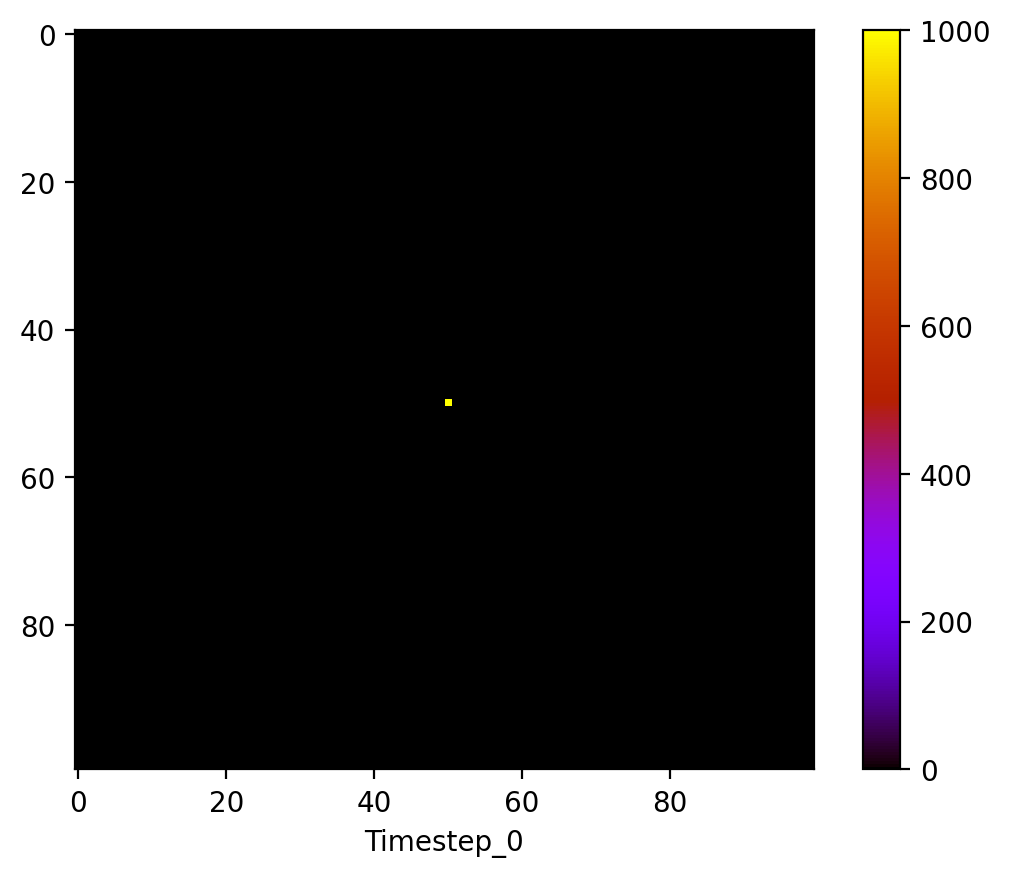

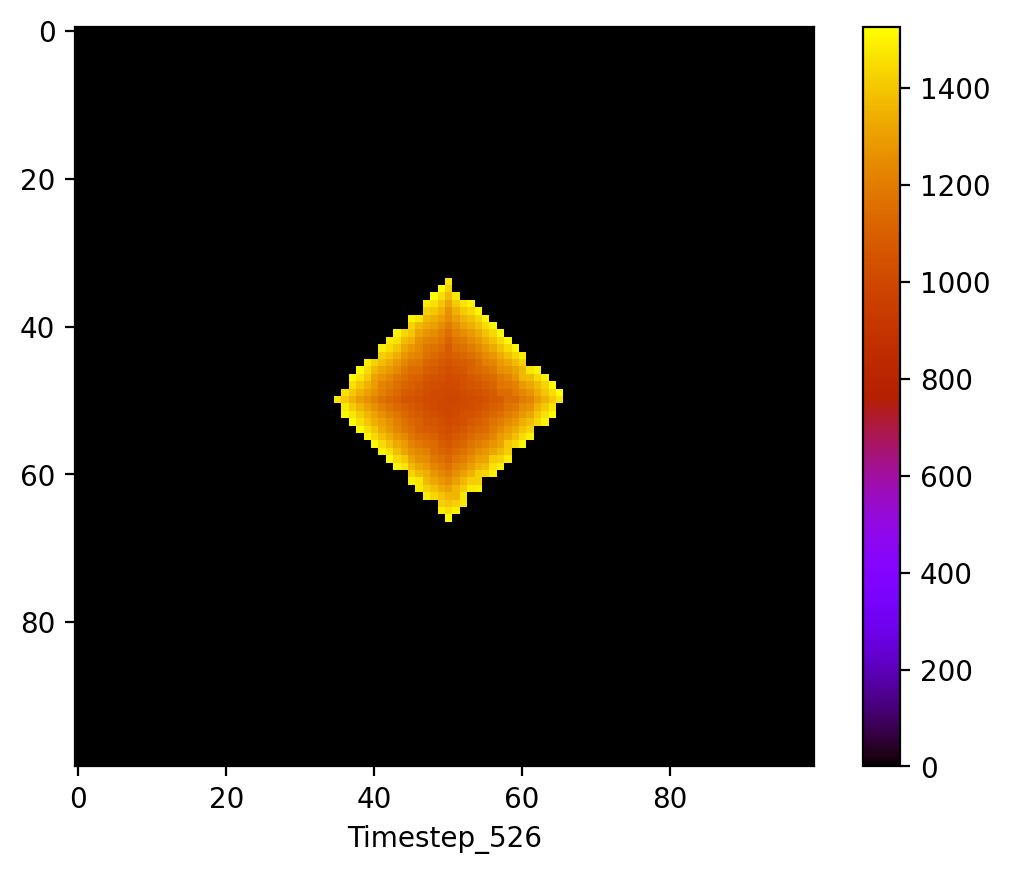

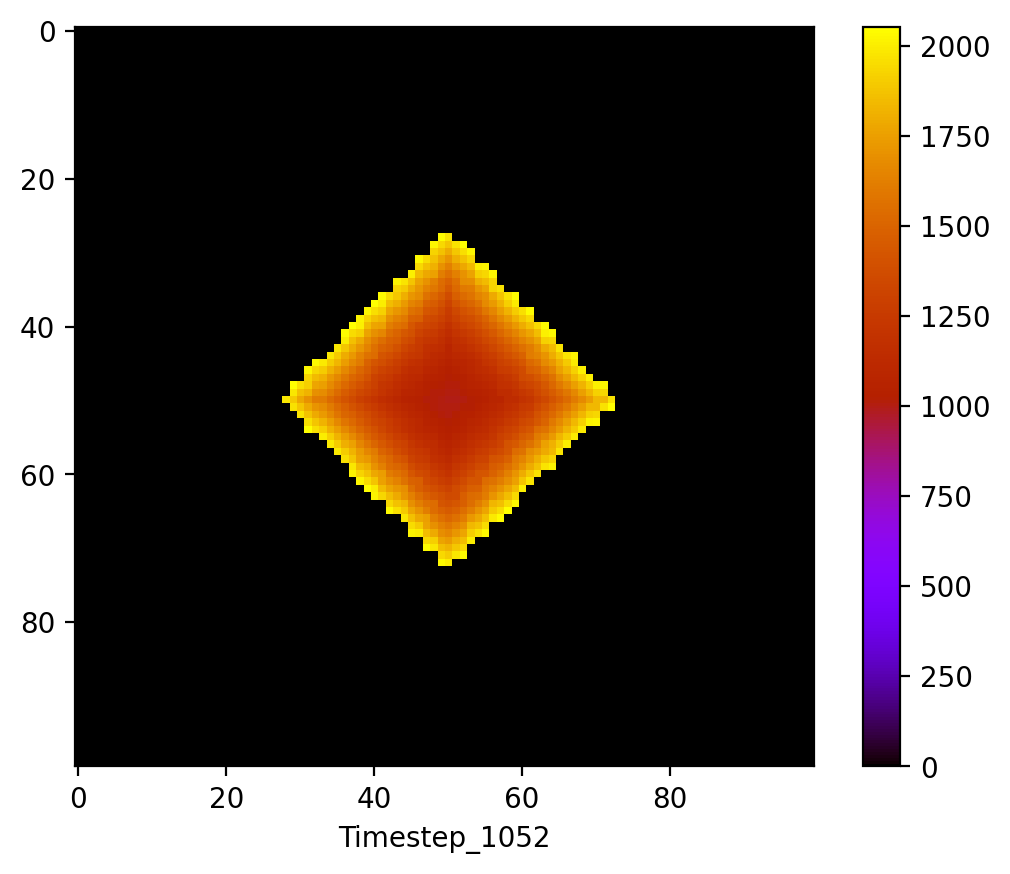

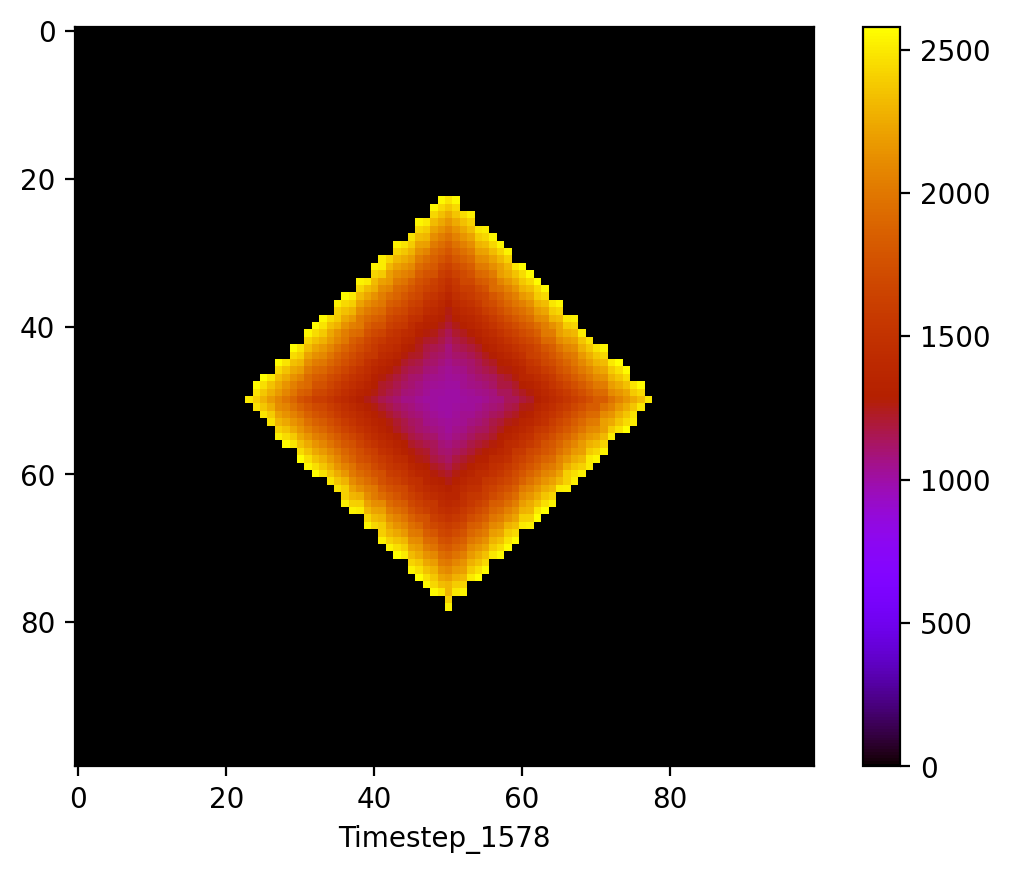

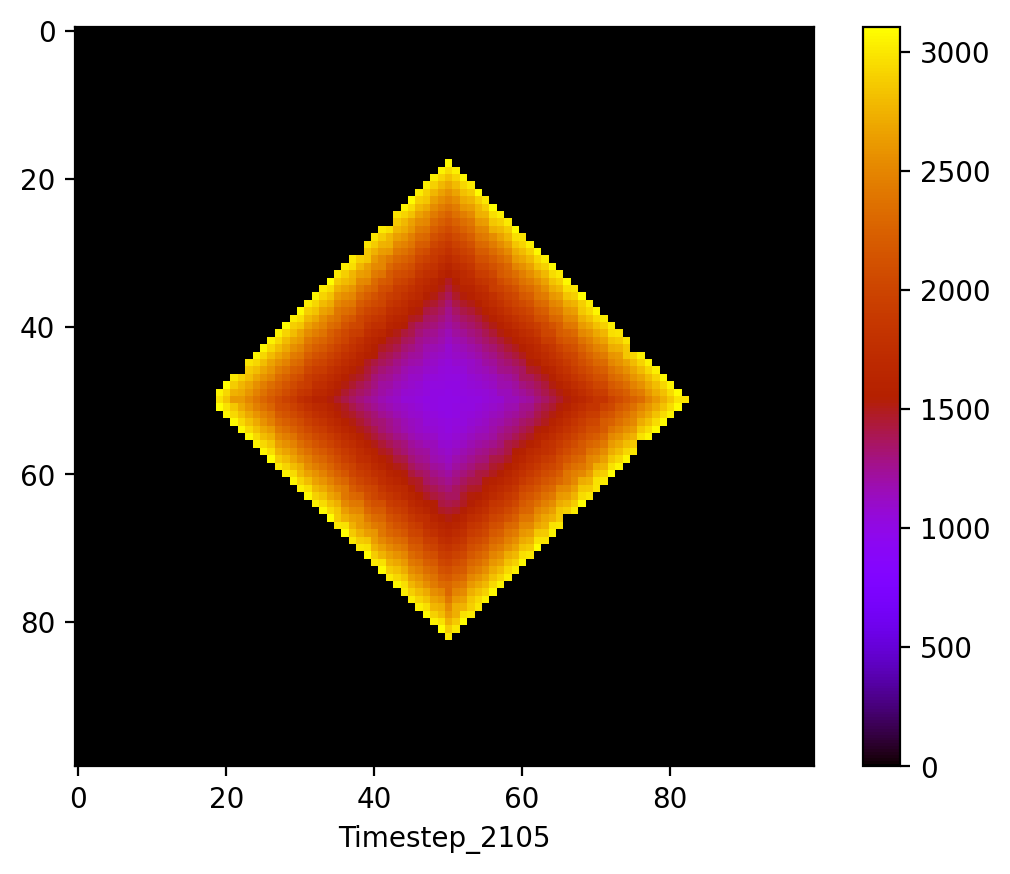

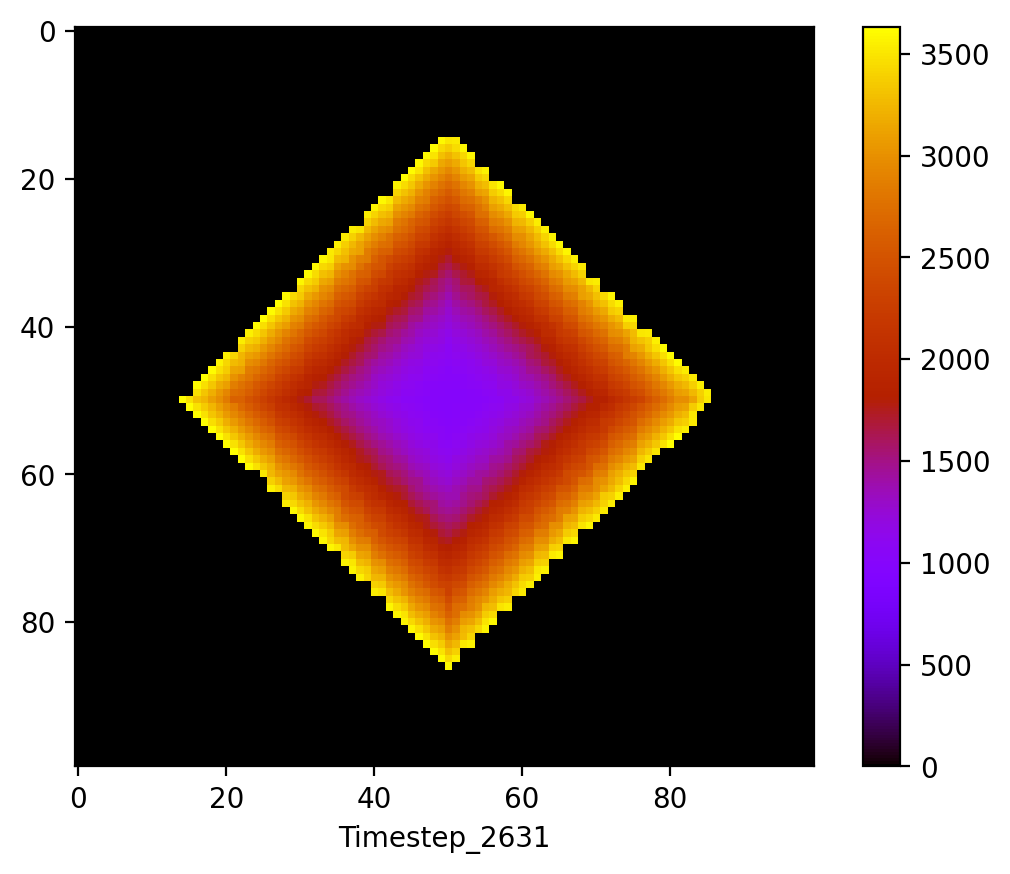

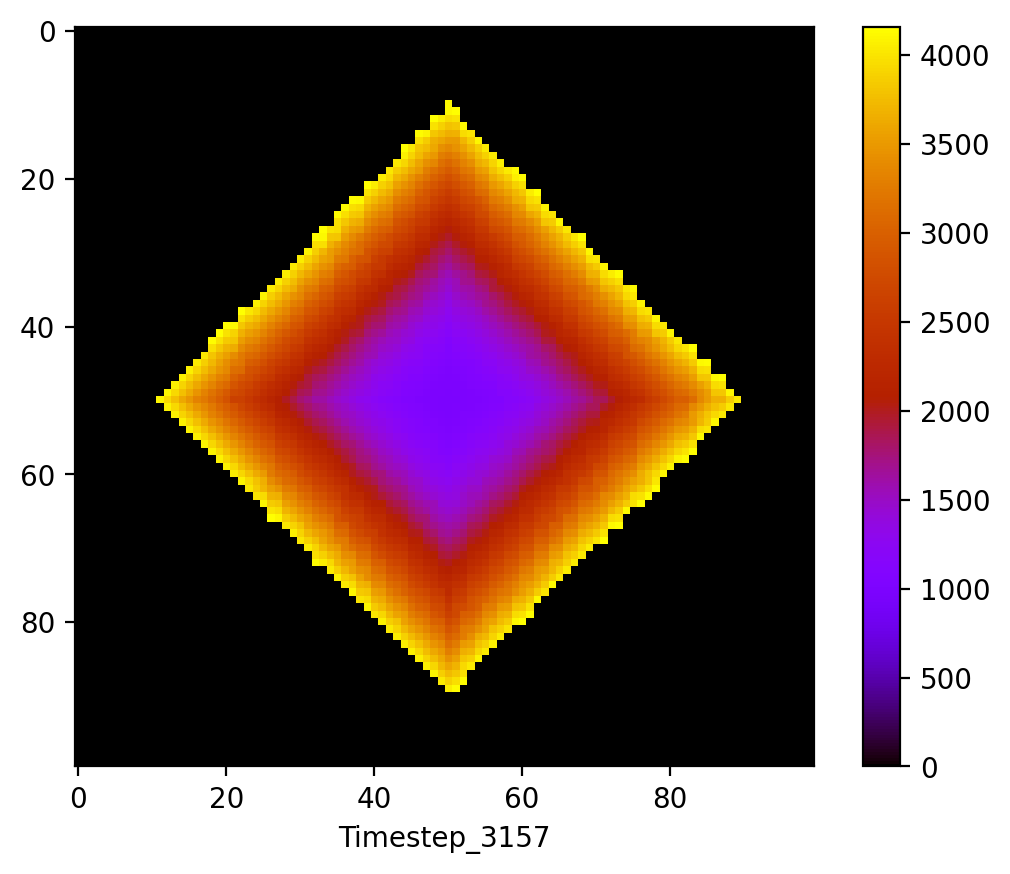

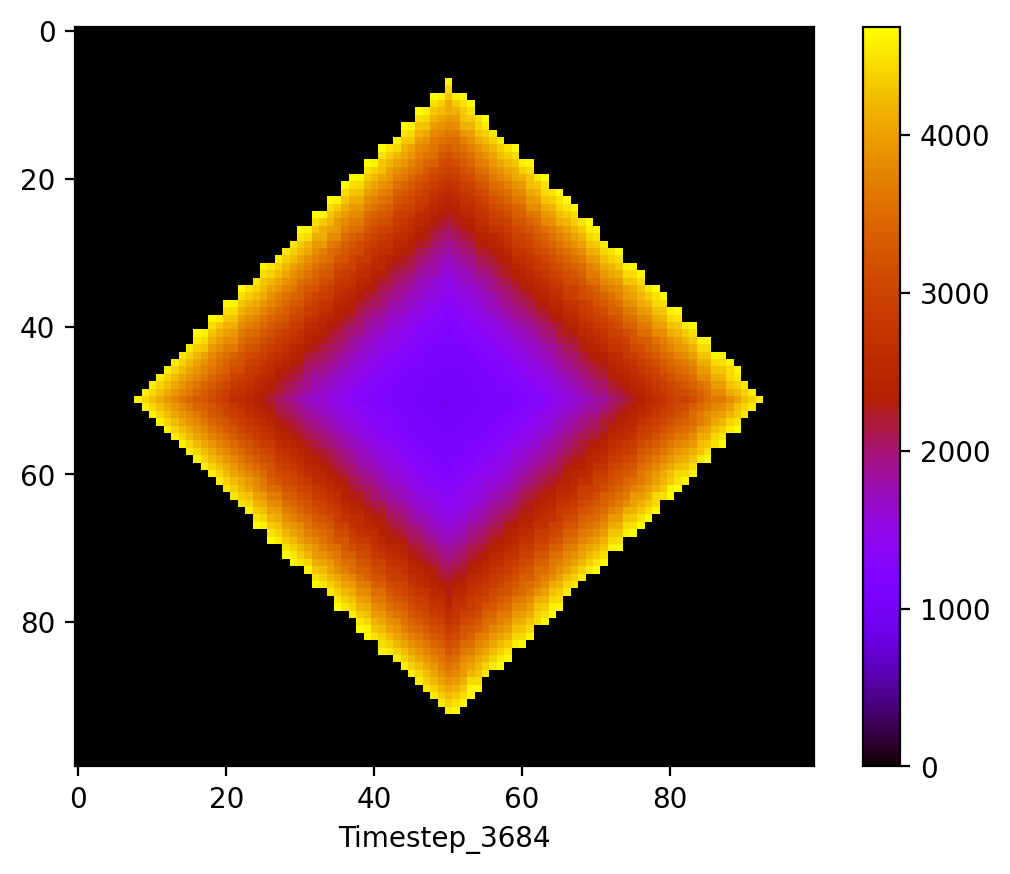

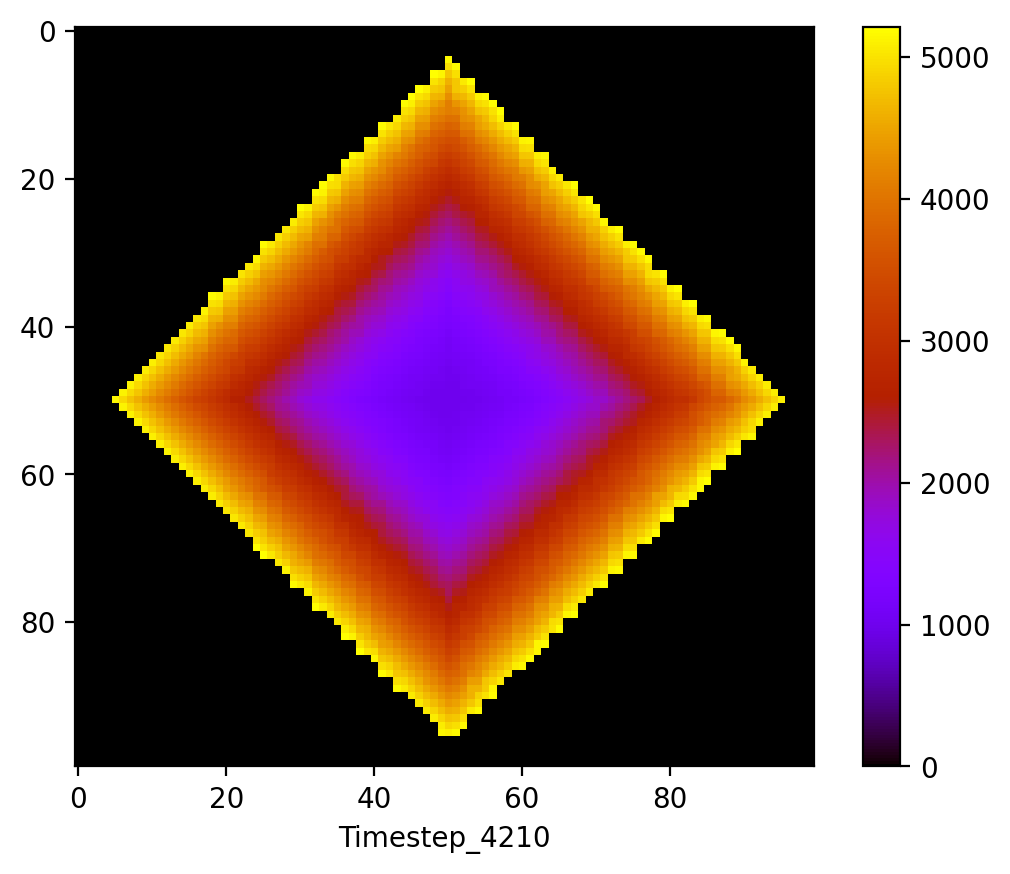

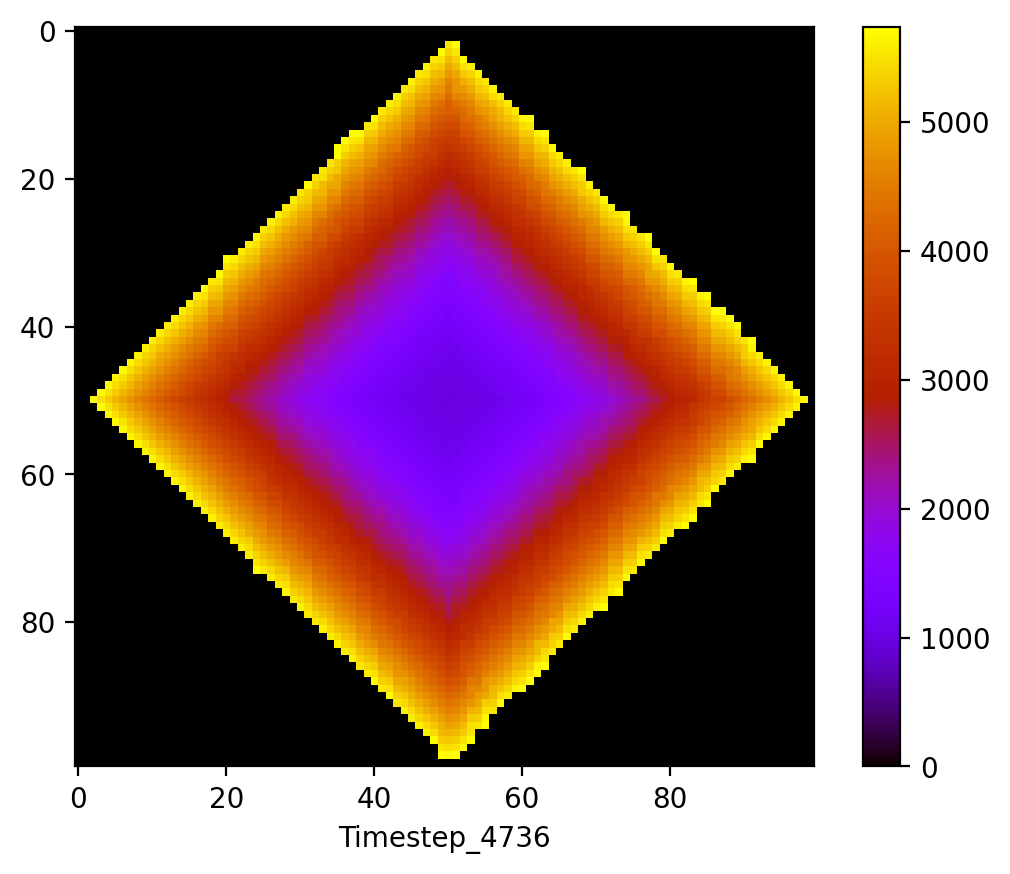

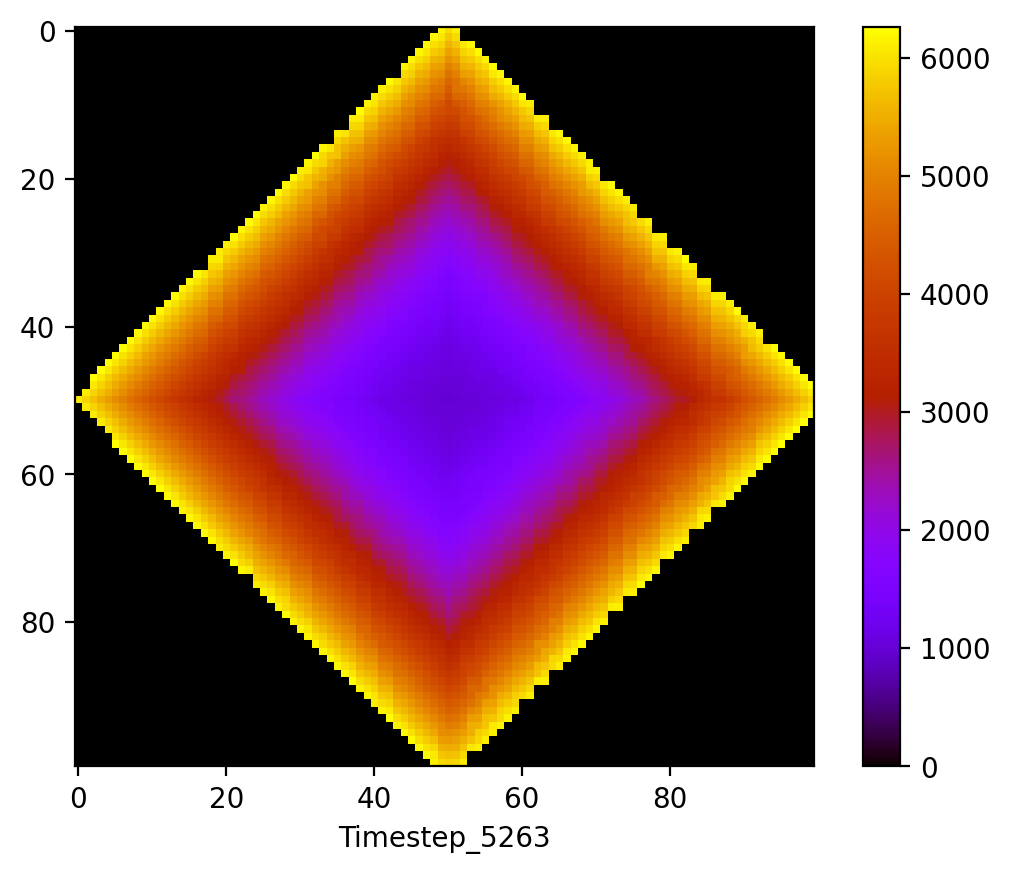

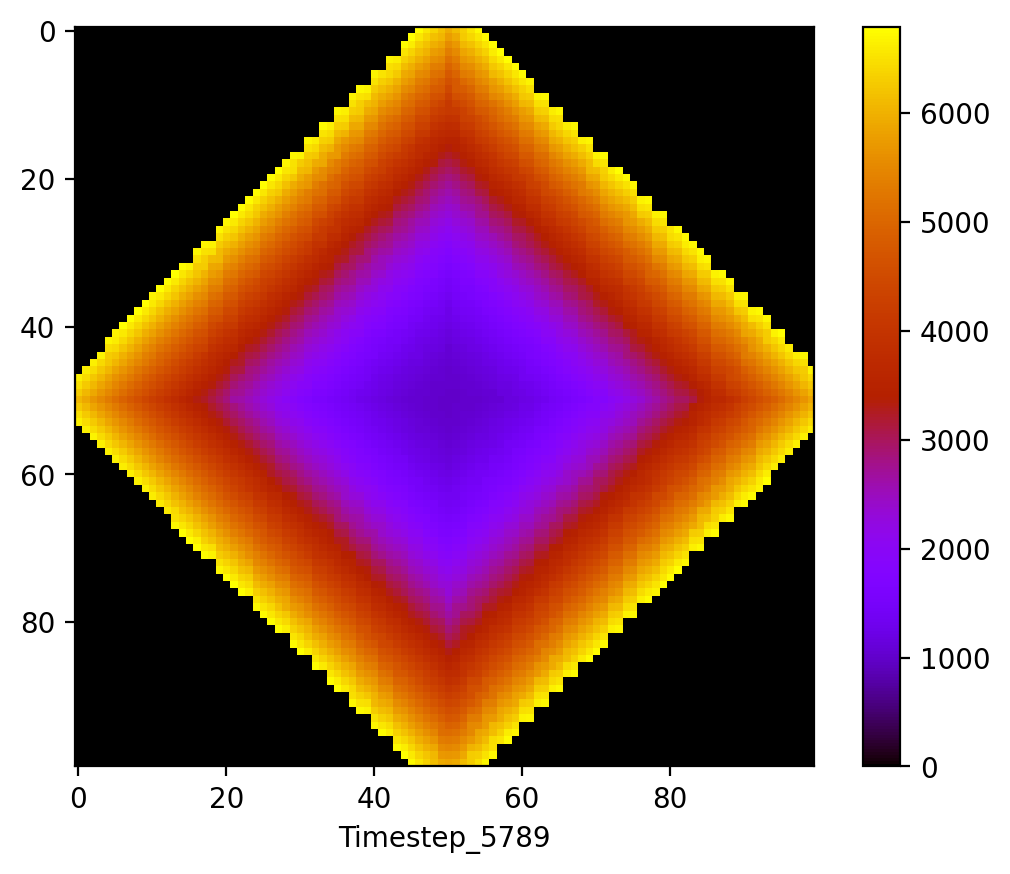

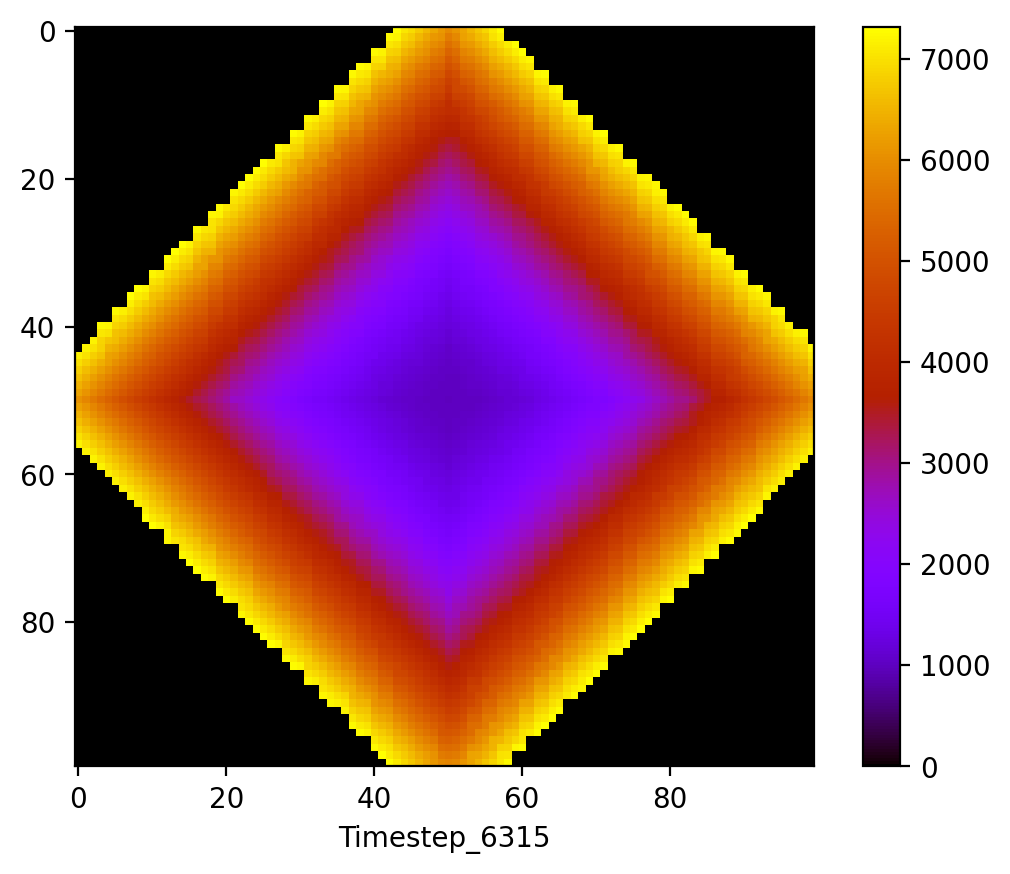

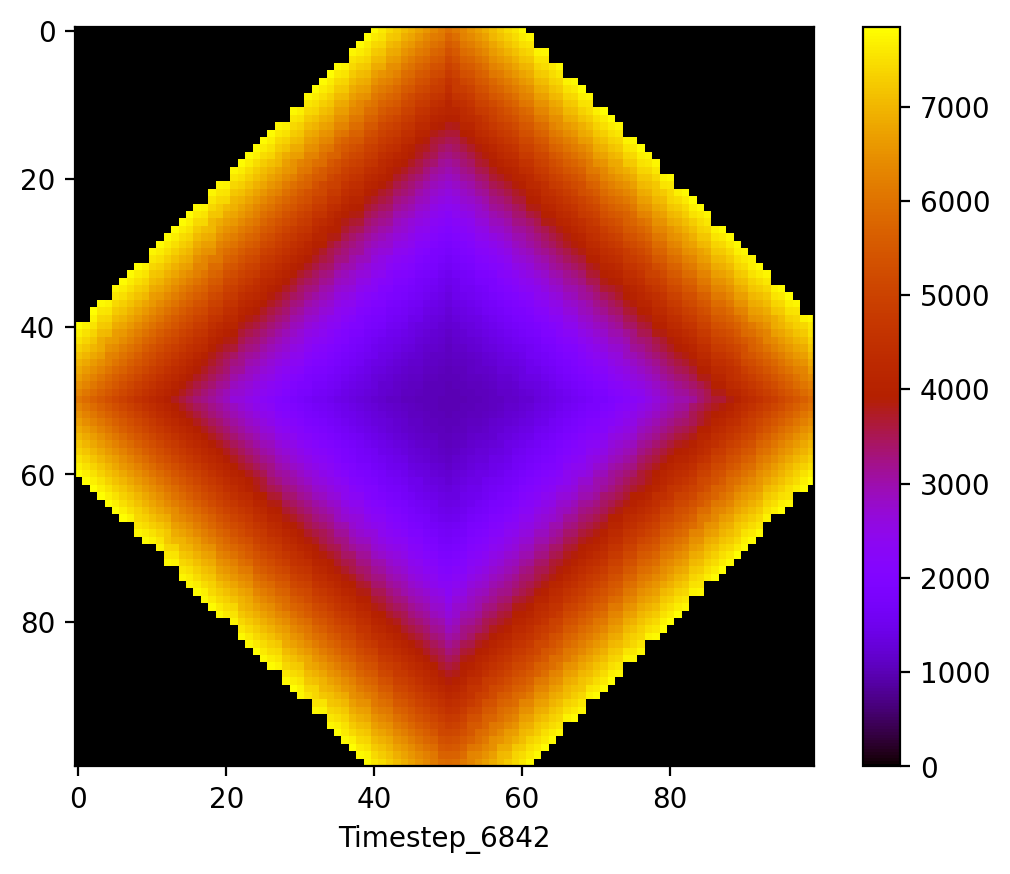

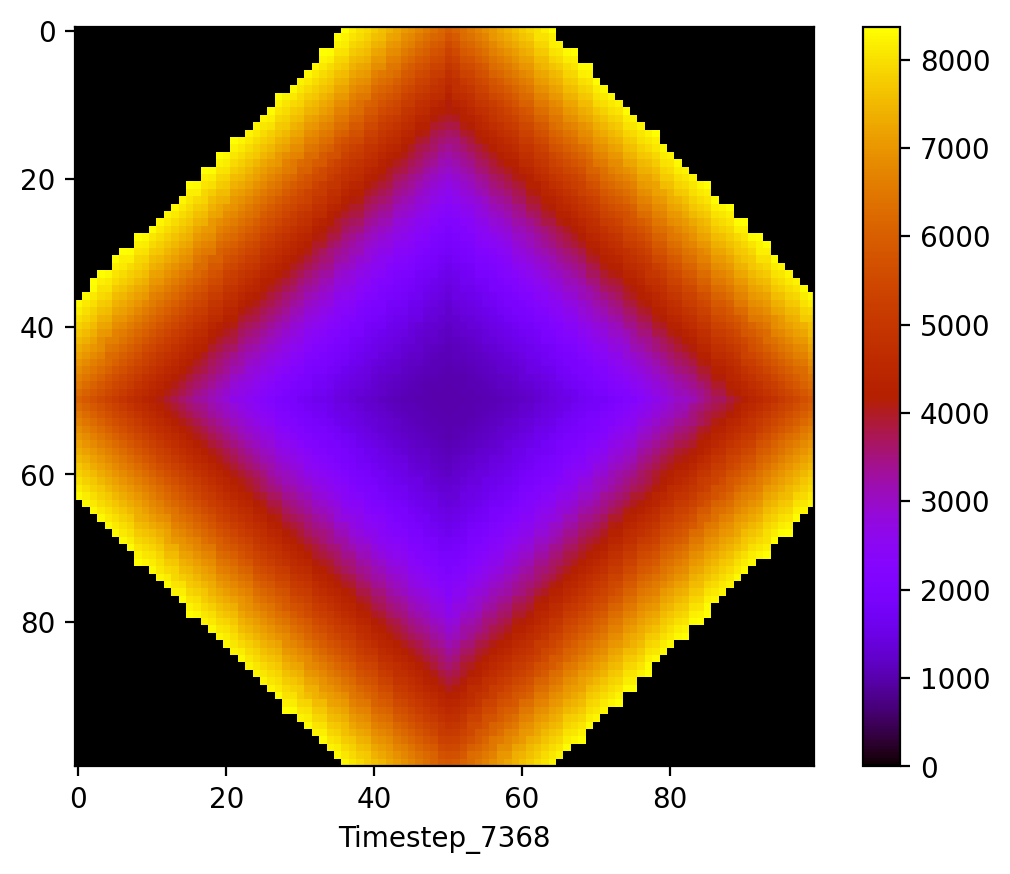

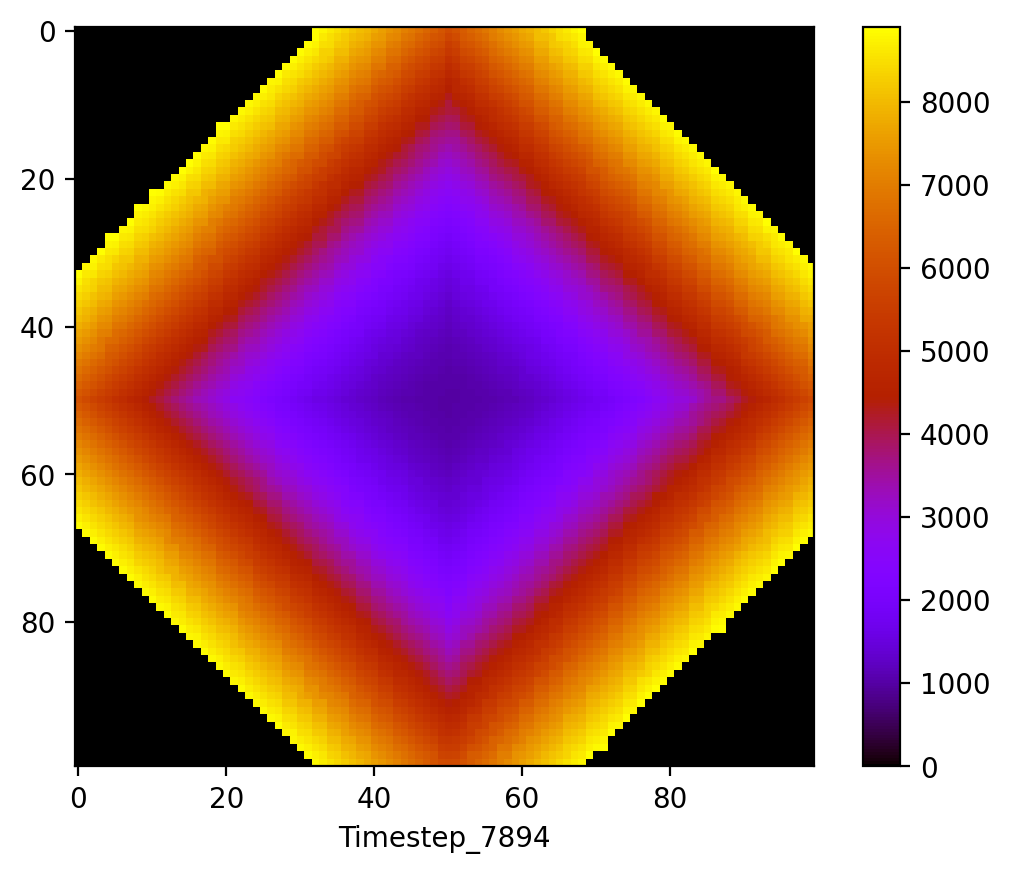

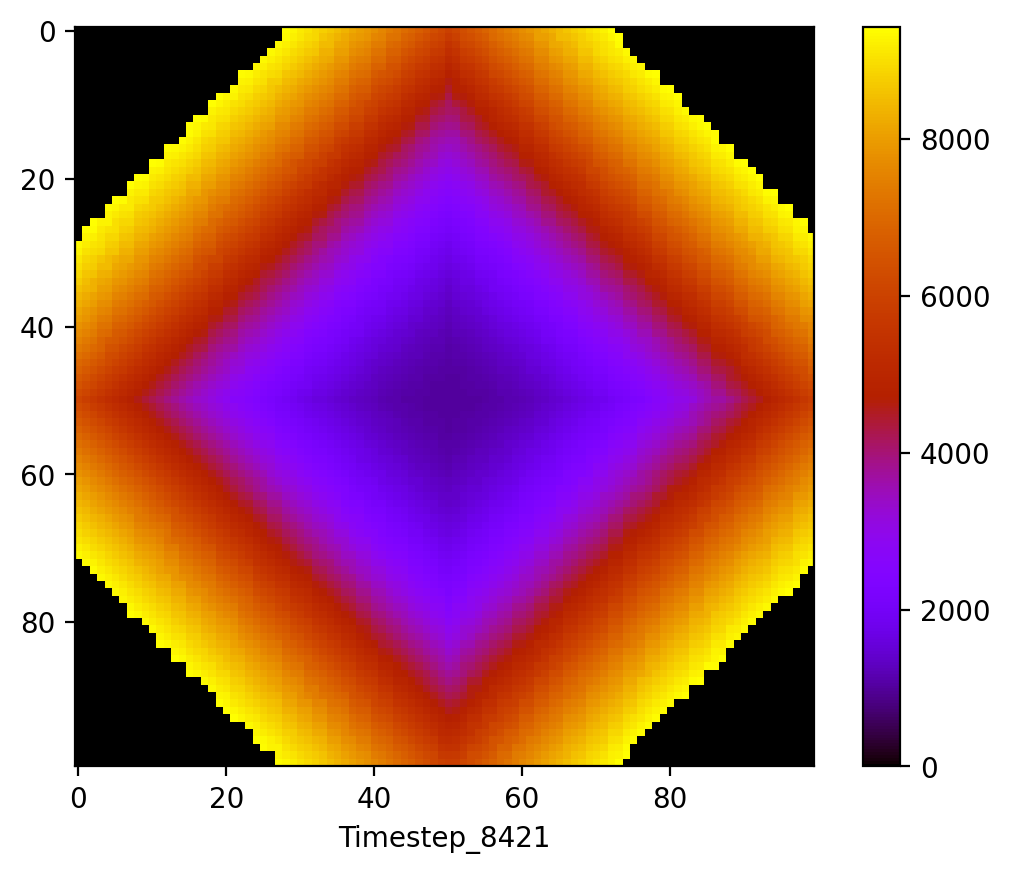

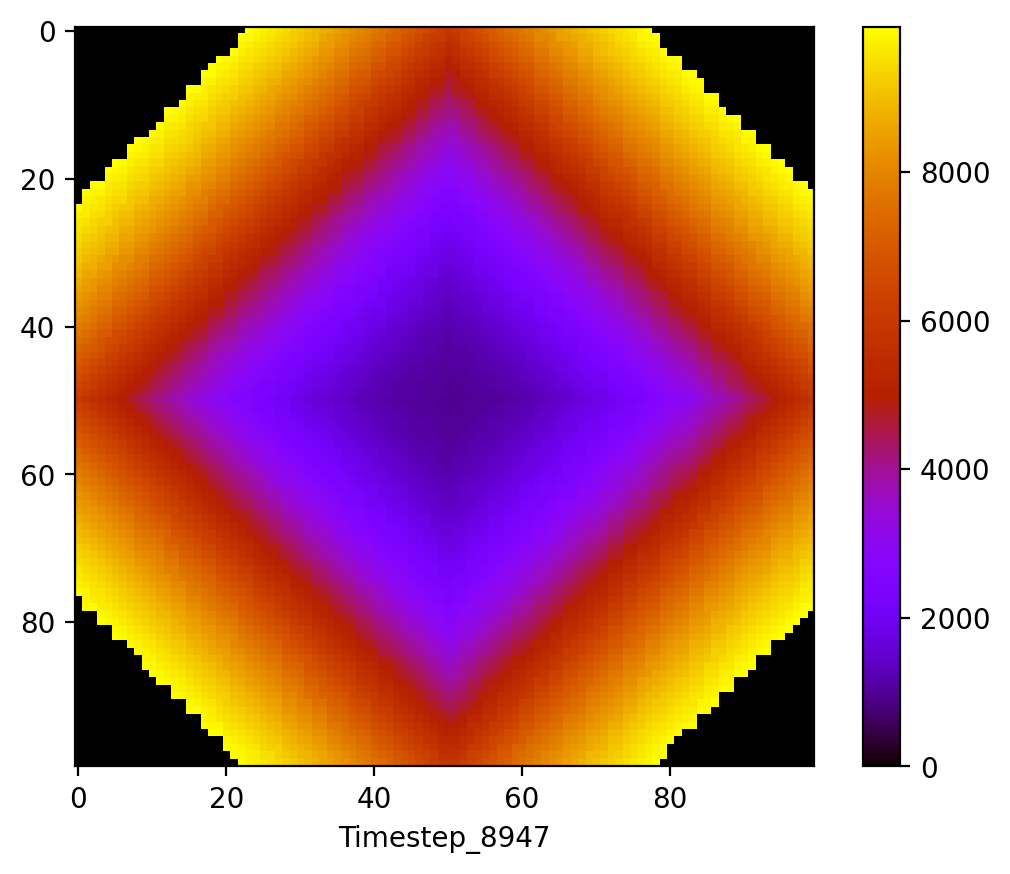

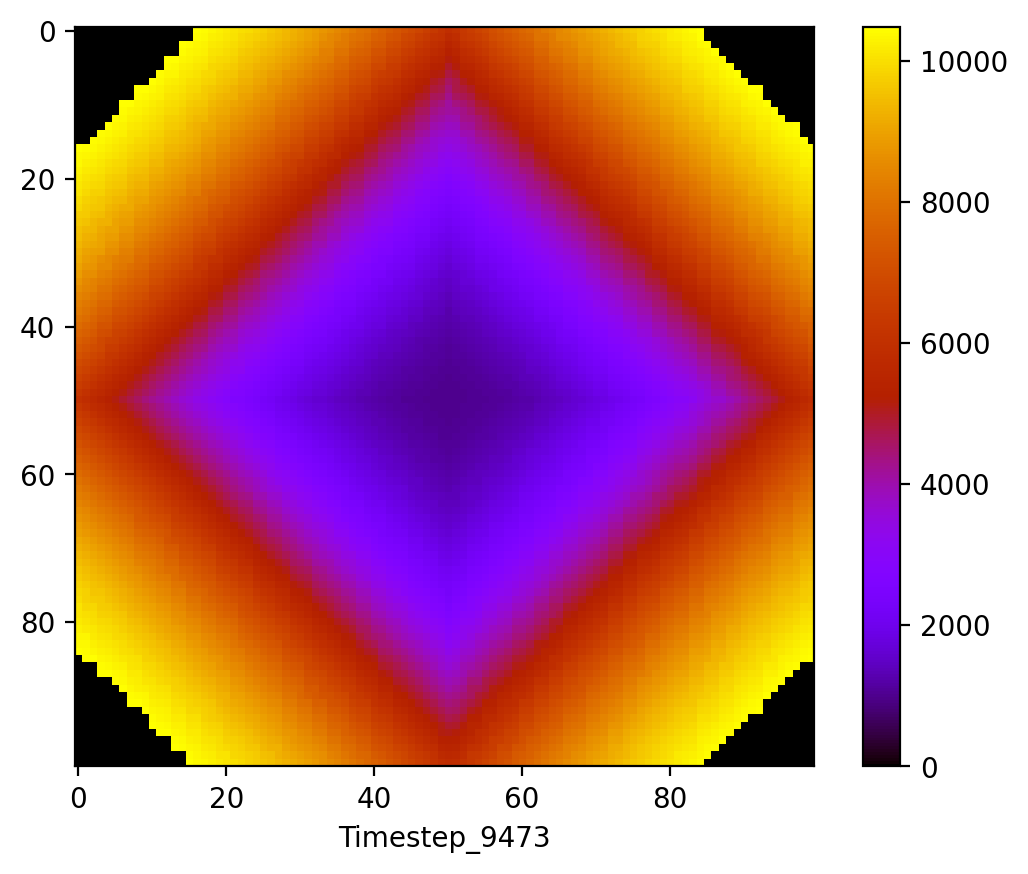

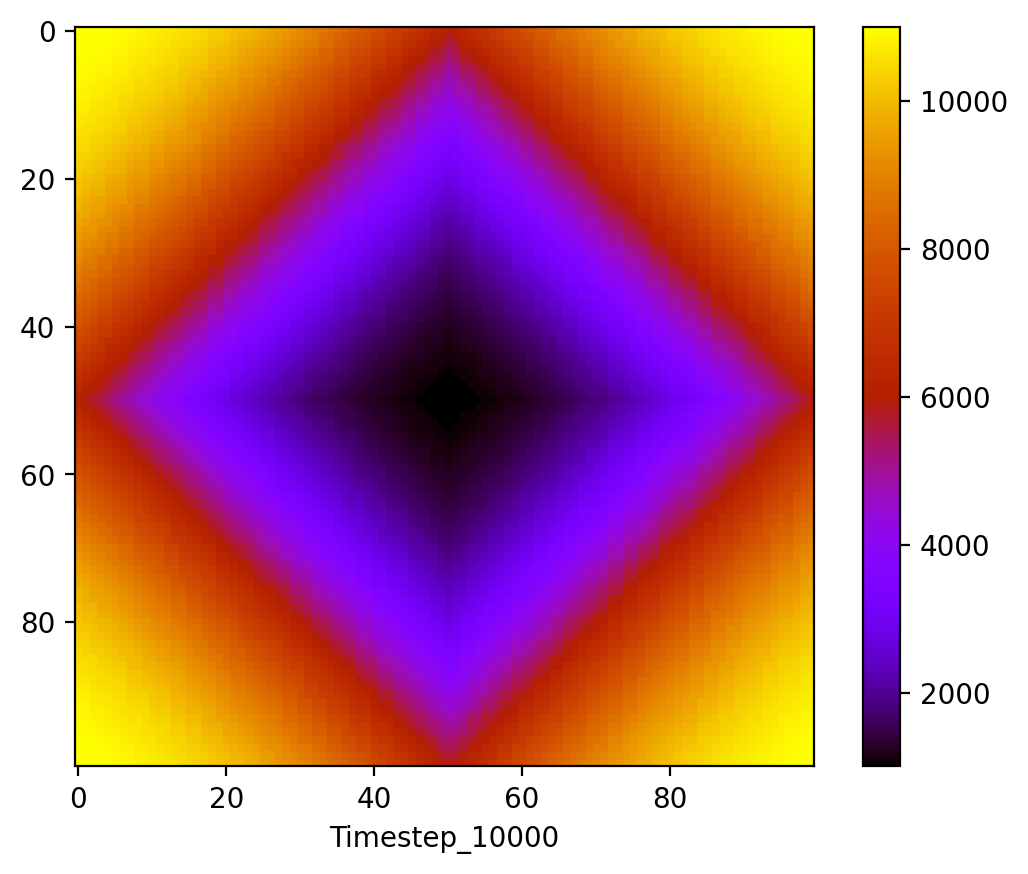

In [ ]:
import matplotlib.pyplot as plt 
'Print Distance Map'
#F = np.zeros(Image.reshape(-1).shape)
s = 100
Time_Steps = [100,200,300,400,500,700,1000,2000,3000,4000,5000]
#Time_Steps = [1000]
for Step in np.linspace(0,10000,20).astype(np.intc):
    s = 1000
    F = np.zeros(np.asarray(Test_new).reshape(-1).shape)
    for i  in Test_Active_List_inf[:]:
        if s <= Step+1000:
            F[i] = s
            s += 1
        else:
            F[i] = 0
    #F[F > 0 ] = 10
    plt.figure(dpi = 200)
    plt.imshow(F.reshape(Test_new.shape),cmap = 'gnuplot')
    plt.colorbar()
    plt.xlabel("Timestep_"+str(Step))
    #plt.tight_layout(.5)
    #plt.savefig("pgf_fonts.pdf")
    #plt.savefig("Tracking_Results/Tracking_"+str(Step)+'.png')

(40, 40)

In [42]:
Heat_Map = np.zeros(Test_new.shape)
Heat_Map.reshape(-1)[Test_Active_List_inf] = Test_Active_Val_inf[::-1]


In [41]:
Heat_Map

array([[0., 1., 2., ..., 3., 2., 1.],
       [1., 2., 3., ..., 4., 3., 2.],
       [2., 3., 4., ..., 5., 4., 3.],
       ...,
       [3., 4., 5., ..., 6., 5., 4.],
       [2., 3., 4., ..., 5., 4., 3.],
       [1., 2., 3., ..., 4., 3., 2.]])

In [127]:
Labeling = np.zeros_like(Test)
Labeling.reshape(-1)[Indices] = 1

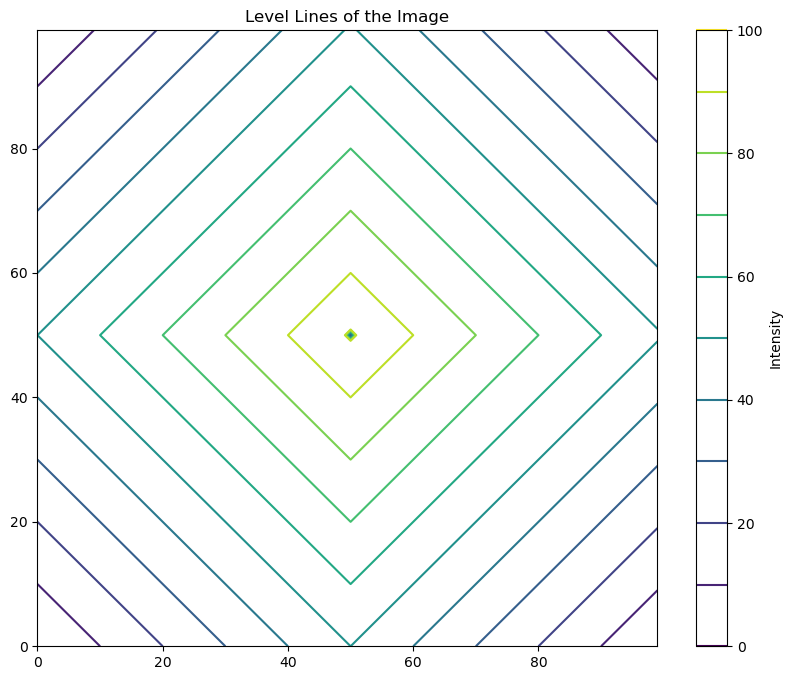

In [21]:
Heat_Map = np.zeros(Test_new.shape)
Heat_Map.reshape(-1)[Test_Active_List_euc] = Test_Active_Val_euc[::-1]
plt.figure(figsize=(10, 8))
plt.contour(Heat_Map, levels=10, cmap='viridis')
plt.title('Level Lines of the Image')
plt.colorbar(label='Intensity')
plt.show()

In [48]:
from bokeh.plotting import figure, show
from bokeh.layouts import row
from bokeh.models import ColorBar, LinearColorMapper, ColumnDataSource

from skimage.measure import find_contours
import numpy as np

Heat_Map = np.zeros(Test_new.shape)
Heat_Map.reshape(-1)[Test_Active_List_inf] = Test_Active_Val_inf[::-1]
Heat_Map_2 = np.zeros(Test_new.shape)
Heat_Map_2.reshape(-1)[Test_Active_List_one] = Test_Active_Val_one[::-1]
Heat_Map_3 = np.zeros(Test_new.shape)
Heat_Map_3.reshape(-1)[Test_Active_List_euc] = Test_Active_Val_euc[::-1]

# Smooth data for contours


# Generate Contour Data
levels = np.linspace(np.min(Heat_Map), np.max(Heat_Map), 10)
contour_lines = [find_contours(Heat_Map, level) for level in levels]

# Generate Contour Data
levels_2 = np.linspace(np.min(Heat_Map_2), np.max(Heat_Map_2), 10)
contour_lines_2 = [find_contours(Heat_Map_2, level) for level in levels_2]

# Generate Contour Data
levels_3 = np.linspace(np.min(Heat_Map_3), np.max(Heat_Map_3), 10)
contour_lines_3 = [find_contours(Heat_Map_3, level) for level in levels_3]

# Prepare Data for Bokeh
xs, ys, colors = [], [], []
for i, contours in enumerate(contour_lines):
    for contour in contours:
        ys.append(contour[:, 0])  # Row indices
        xs.append(contour[:, 1])  # Column indices
        colors.append(levels[i])  # Add level as color

# Create a ColumnDataSource
source = ColumnDataSource(data=dict(xs=xs, ys=ys, color=colors))

# Color Mapper
mapper = LinearColorMapper(palette="Viridis256", low=np.min(levels), high=np.max(levels))


xs, ys, colors = [], [], []
for i, contours in enumerate(contour_lines_2):
    for contour in contours:
        ys.append(contour[:, 0])  # Row indices
        xs.append(contour[:, 1])  # Column indices
        colors.append(levels_2[i])  # Add level as color

# Create a ColumnDataSource
source_2 = ColumnDataSource(data=dict(xs=xs, ys=ys, color=colors))

# Color Mapper
mapper_2 = LinearColorMapper(palette="Viridis256", low=np.min(levels_2), high=np.max(levels_2))

xs, ys, colors = [], [], []
for i, contours in enumerate(contour_lines_3):
    for contour in contours:
        ys.append(contour[:, 0])  # Row indices
        xs.append(contour[:, 1])  # Column indices
        colors.append(levels_3[i])  # Add level as color

# Create a ColumnDataSource
source_3 = ColumnDataSource(data=dict(xs=xs, ys=ys, color=colors))

# Color Mapper
mapper_3 = LinearColorMapper(palette="Viridis256", low=np.min(levels_3), high=np.max(levels_3))

# Create individual plots
plots = []
titles = ["Plot 1: Inf-Norm", "Plot 2: 1-Norm", "Plot 3: Euclidian Norm"]

# Plot 1: Heat Map
p1 = figure(
    title=titles[0],
    width=300,
    height=300,
    tools="pan,box_zoom,reset,save",
    x_axis_label="X-axis",
    y_axis_label="Y-axis",
)
p2.multi_line(xs='xs', ys='ys', line_width=2, line_color={'field': 'color', 'transform': mapper}, source=source)
color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0, 0), title="Intensity Level")
p1.add_layout(color_bar, 'right')

# Plot 2: Contour Lines
p2 = figure(
    title=titles[1],
    width=300,
    height=300,
    tools="pan,box_zoom,reset,save",
    x_axis_label="X-axis",
    y_axis_label="Y-axis",
)
p2.multi_line(xs='xs', ys='ys', line_width=2, line_color={'field': 'color', 'transform': mapper_2}, source=source_2)

# Plot 3: Combined View
p3 = figure(
    title=titles[2],
    width=300,
    height=300,
    tools="pan,box_zoom,reset,save",
    x_axis_label="X-axis",
    y_axis_label="Y-axis",
)
p3.multi_line(xs='xs', ys='ys', line_width=2, line_color={'field': 'color', 'transform': mapper_3}, source=source_3)
p3.add_layout(color_bar, 'right')

# Arrange plots in a row
layout = row(p1, p2, p3)

# Show the layout
show(layout)


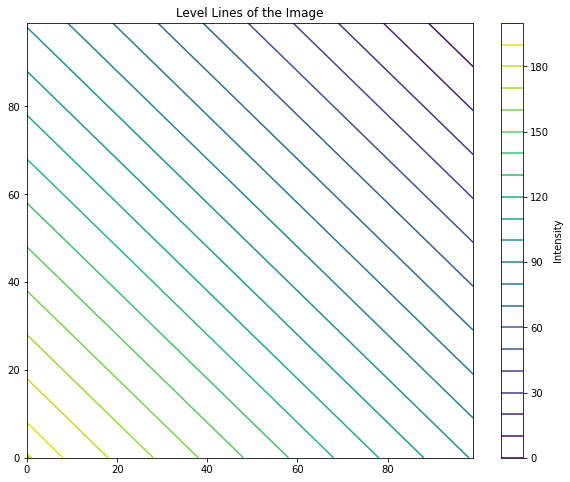

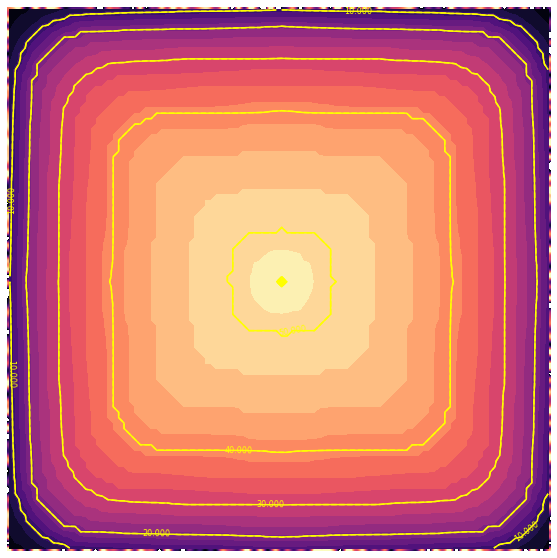

In [467]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
grid = np.random.uniform(0, 100, (100, 100))
heatmap = plt.imshow(grid, cmap='magma', interpolation='lanczos')
# Filled contour plot for better visualization
plt.contourf(Heat_Map, levels=20, cmap='magma')
levels = [i for i in range(0,70, 10)]
contours = plt.contour(Heat_Map, levels=levels, colors='yellow', linestyles='dashed')

# Add a thicker solid line at level 0 if applicable
plt.contour(Heat_Map, levels=levels, colors='yellow', linewidths=1.5)

# Label the contour lines directly
plt.clabel(contours, inline=True, fontsize=8)
plt.axis("off")


plt.show()


In [489]:
import imageio
import matplotlib.cm as cm
import matplotlib
# Create an array to store the generated frames
frames = []

# Generate the random grid for the heatmap
grid = np.random.uniform(0, 100, (100, 100))

# Define the levels for contour lines
levels_list = range(0,72,10)  # Different levels for each frame

# Generate frames for different levels
for levels_end in reversed(levels_list):
    levels = [i for i in range(0,levels_end, 10)]
    print(levels_end)
    #print(int(levels/10))
    Heat_Map_aux = Heat_Map.copy()
    Heat_Map_aux[np.where(Heat_Map_aux<levels_end)] = -1
    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = cm.get_cmap('magma')
    n=80-levels_end
    white = np.ones((1,4))
    upper = cmap(np.linspace(0, 1, 72))
    colors = np.vstack((white, upper))
    tmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', colors)
    #Heat_Map_aux.reshape(-1)[Mask[0]] = 0

    # Display heatmap
    # Filled contour plot
    ax.contourf(Heat_Map_aux, levels=20, cmap = tmap,vmin=0, vmax=100)

    # Dashed contour lines


    # Solid lines for contour (same levels)
    if levels_end == 70:
        contours = ax.contour(Heat_Map_aux, levels=10, linestyles='dashed',cmap=tmap)
    ax.contour(Heat_Map_aux, levels=10, colors='yellow', linewidths=1.5)
    # Label the contour lines
    #ax.clabel(contours, inline=True, fontsize=8)

    # Remove axis for clean visuals
    ax.axis("off")
    plt.tight_layout()
    #plt.colorbar(Heat_Map_aux)
    # Save the current figure as an image and add it to frames list
    plt.savefig('frame.png')
    frames.append(imageio.imread('frame.png'))

    # Close the figure to save memory
    plt.close()

# Create a GIF from the frames
imageio.mimsave('FM_L_inf.gif', frames, fps=3)

print("GIF has been created!")

70
60
50
40
30
20
10
0
GIF has been created!
